In [2]:
import requests
import sqlite3
import time

# -------------------------
# إعداد قاعدة البيانات
# -------------------------
DB_NAME = "movies.db"
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

# -------------------------
# إنشاء الجداول إذا لم تكن موجودة
# -------------------------
cursor.execute("""
CREATE TABLE IF NOT EXISTS Genres (
    GenreID INTEGER PRIMARY KEY,
    GenreName TEXT
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Movies (
    MovieID INTEGER PRIMARY KEY,
    Title TEXT,
    ReleaseYear INTEGER,
    Rating REAL
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS MovieGenres (
    MovieID INTEGER,
    GenreID INTEGER,
    PRIMARY KEY (MovieID, GenreID),
    FOREIGN KEY (MovieID) REFERENCES Movies(MovieID),
    FOREIGN KEY (GenreID) REFERENCES Genres(GenreID)
)
""")
conn.commit()

# -------------------------
# إعداد TMDB API v3
# -------------------------
API_KEY = "e92317fcc1f88bfbfdc8894d93c07a70"  # مفتاحك v3
BASE_URL = "https://api.themoviedb.org/3/discover/movie"
GENRE_URL = "https://api.themoviedb.org/3/genre/movie/list"

# -------------------------
# جلب أسماء التصنيفات
# -------------------------
response = requests.get(GENRE_URL, params={"api_key": API_KEY, "language": "en-US"})
genres_dict = {}
if response.status_code == 200:
    data = response.json()
    for g in data["genres"]:
        genres_dict[g["id"]] = g["name"]
else:
    raise Exception(f"Failed to fetch genres: {response.status_code} - {response.text}")

# -------------------------
# دوال إدخال البيانات
# -------------------------
def insert_genre(genre_id, genre_name):
    cursor.execute("SELECT 1 FROM Genres WHERE GenreID=?", (genre_id,))
    if cursor.fetchone() is None:
        cursor.execute("INSERT INTO Genres (GenreID, GenreName) VALUES (?, ?)", (genre_id, genre_name))

def insert_movie(movie):
    movie_id = movie["id"]
    title = movie["title"]
    release_date = movie.get("release_date", "")
    release_year = int(release_date[:4]) if release_date else None
    rating = movie.get("vote_average", 0)

    cursor.execute("SELECT 1 FROM Movies WHERE MovieID=?", (movie_id,))
    if cursor.fetchone() is None:
        cursor.execute(
            "INSERT INTO Movies (MovieID, Title, ReleaseYear, Rating) VALUES (?, ?, ?, ?)",
            (movie_id, title, release_year, rating)
        )

def insert_movie_genres(movie):
    movie_id = movie["id"]
    for genre_id in movie.get("genre_ids", []):
        genre_name = genres_dict.get(genre_id, f"Unknown_{genre_id}")
        insert_genre(genre_id, genre_name)
        cursor.execute(
            "INSERT OR IGNORE INTO MovieGenres (MovieID, GenreID) VALUES (?, ?)",
            (movie_id, genre_id)
        )

# -------------------------
# جلب البيانات مع Pagination و Rate Limit
# -------------------------
def fetch_movies(pages=5, sleep_time=2):
    for page in range(1, pages + 1):
        print(f"Fetching page {page}...")
        params = {
            "api_key": API_KEY,
            "page": page,
            "language": "en-US"
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            data = response.json()
            for movie in data.get("results", []):
                insert_movie(movie)
                insert_movie_genres(movie)
            conn.commit()
            time.sleep(sleep_time)  # لتجنب Rate Limit
        elif response.status_code == 429:
            print("Rate limit reached. Waiting 10 seconds...")
            time.sleep(10)
            page -= 1  # إعادة المحاولة لنفس الصفحة
        else:
            print(f"Error {response.status_code}: {response.text}")

# -------------------------
# تنفيذ الجلب
# -------------------------
fetch_movies(pages=5, sleep_time=2)
conn.close()
print("Data fetching completed successfully!")


Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Data fetching completed successfully!


In [3]:
import sqlite3

conn = sqlite3.connect("movies.db")
cursor = conn.cursor()

# تحقق من أول 5 أفلام
cursor.execute("SELECT * FROM Movies LIMIT 5")
print(cursor.fetchall())

# تحقق من التصنيفات
cursor.execute("SELECT * FROM Genres")
print(cursor.fetchall())

# تحقق من ربط الأفلام بالتصنيفات
cursor.execute("SELECT * FROM MovieGenres LIMIT 10")
print(cursor.fetchall())

conn.close()


[(238, 'The Godfather', 1972, 8.685), (278, 'The Shawshank Redemption', 1994, 8.714), (601, 'E.T. the Extra-Terrestrial', 1982, 7.512), (772, 'Home Alone 2: Lost in New York', 1992, 6.77), (7451, 'xXx', 2002, 5.976)]
[(12, 'Adventure'), (14, 'Fantasy'), (16, 'Animation'), (18, 'Drama'), (27, 'Horror'), (28, 'Action'), (35, 'Comedy'), (36, 'History'), (37, 'Western'), (53, 'Thriller'), (80, 'Crime'), (878, 'Science Fiction'), (9648, 'Mystery'), (10402, 'Music'), (10749, 'Romance'), (10751, 'Family'), (10752, 'War')]
[(83533, 878), (83533, 12), (83533, 14), (982843, 878), (982843, 12), (982843, 18), (425274, 53), (425274, 80), (425274, 9648), (1084242, 16)]


In [4]:
import requests
import sqlite3
import time
import json
import os

DB_NAME = "movies.db"
API_KEY = "e92317fcc1f88bfbfdc8894d93c07a70"  # مفتاحك v3
BASE_URL = "https://api.themoviedb.org/3/discover/movie"
GENRE_URL = "https://api.themoviedb.org/3/genre/movie/list"
PROGRESS_FILE = "progress.json"  # لتخزين آخر صفحة تم جلبها

# -------------------------
# إنشاء قاعدة البيانات
# -------------------------
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS Genres (
    GenreID INTEGER PRIMARY KEY,
    GenreName TEXT
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Movies (
    MovieID INTEGER PRIMARY KEY,
    Title TEXT,
    ReleaseYear INTEGER,
    Rating REAL
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS MovieGenres (
    MovieID INTEGER,
    GenreID INTEGER,
    PRIMARY KEY (MovieID, GenreID),
    FOREIGN KEY (MovieID) REFERENCES Movies(MovieID),
    FOREIGN KEY (GenreID) REFERENCES Genres(GenreID)
)
""")
conn.commit()

# -------------------------
# جلب التصنيفات
# -------------------------
response = requests.get(GENRE_URL, params={"api_key": API_KEY, "language": "en-US"})
if response.status_code == 200:
    data = response.json()
    genres_dict = {g["id"]: g["name"] for g in data["genres"]}
else:
    raise Exception(f"Failed to fetch genres: {response.status_code} - {response.text}")

# -------------------------
# دوال إدخال البيانات
# -------------------------
def insert_genre(genre_id, genre_name):
    cursor.execute(
        "INSERT OR IGNORE INTO Genres (GenreID, GenreName) VALUES (?, ?)",
        (genre_id, genre_name)
    )

def insert_movie(movie):
    movie_id = movie["id"]
    title = movie["title"]
    release_date = movie.get("release_date", "")
    try:
        release_year = int(release_date[:4])
    except (ValueError, TypeError):
        release_year = None
    rating = movie.get("vote_average", 0)

    cursor.execute(
        "INSERT OR IGNORE INTO Movies (MovieID, Title, ReleaseYear, Rating) VALUES (?, ?, ?, ?)",
        (movie_id, title, release_year, rating)
    )

def insert_movie_genres(movie):
    movie_id = movie["id"]
    for genre_id in movie.get("genre_ids", []):
        genre_name = genres_dict.get(genre_id, f"Unknown_{genre_id}")
        insert_genre(genre_id, genre_name)
        cursor.execute(
            "INSERT OR IGNORE INTO MovieGenres (MovieID, GenreID) VALUES (?, ?)",
            (movie_id, genre_id)
        )

# -------------------------
# دالة لجلب صفحة واحدة مع التعامل مع Rate Limit
# -------------------------
def fetch_page(page):
    while True:
        response = requests.get(BASE_URL, params={"api_key": API_KEY, "page": page, "language": "en-US"})
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print("Rate limit reached. Waiting 10 seconds...")
            time.sleep(10)
        else:
            print(f"Error {response.status_code}: {response.text}")
            time.sleep(5)

# -------------------------
# حفظ واستئناف التقدم
# -------------------------
def load_progress():
    if os.path.exists(PROGRESS_FILE):
        with open(PROGRESS_FILE, "r") as f:
            return json.load(f).get("last_page", 1)
    return 1

def save_progress(page):
    with open(PROGRESS_FILE, "w") as f:
        json.dump({"last_page": page}, f)

# -------------------------
# جلب جميع الصفحات
# -------------------------
def fetch_movies(max_pages=None, sleep_time=1):
    page = load_progress()
    total_pages = max_pages or float('inf')

    while page <= total_pages:
        print(f"Fetching page {page}...")
        data = fetch_page(page)

        # تحديث إجمالي الصفحات بناءً على أول استدعاء
        if max_pages is None:
            total_pages = data.get("total_pages", page)

        for movie in data.get("results", []):
            insert_movie(movie)
            insert_movie_genres(movie)

        conn.commit()
        save_progress(page)
        page += 1
        time.sleep(sleep_time)  # لتجنب Rate Limit

# -------------------------
# بدء الجلب
# -------------------------
try:
    fetch_movies(max_pages=1000, sleep_time=1)  # يمكنك زيادة max_pages أو تركه None لجلب كل الأفلام
finally:
    conn.close()
    print("Data fetching completed successfully!")


Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Fetching page 25...
Fetching page 26...
Fetching page 27...
Fetching page 28...
Fetching page 29...
Fetching page 30...
Fetching page 31...
Fetching page 32...
Fetching page 33...
Fetching page 34...
Fetching page 35...
Fetching page 36...
Fetching page 37...
Fetching page 38...
Fetching page 39...
Fetching page 40...
Fetching page 41...
Fetching page 42...
Fetching page 43...
Fetching page 44...
Fetching page 45...
Fetching page 46...
Fetching page 47...
Fetching page 48...
Fetching page 49...
Fetching page 50...
Fetching 

KeyboardInterrupt: 

In [5]:
import sqlite3

conn = sqlite3.connect("movies.db")
cursor = conn.cursor()

cursor.execute("SELECT COUNT(*) FROM Movies")
total_movies = cursor.fetchone()[0]
print(f"Total movies in database: {total_movies}")

conn.close()


Total movies in database: 9865


In [6]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("movies.db")
cursor = conn.cursor()

# عرض أول 5 أفلام
df = pd.read_sql_query("SELECT * FROM Movies LIMIT 5", conn)
print(df)

conn.close()


   MovieID            Title  ReleaseYear  Rating
0        5       Four Rooms         1995   5.877
1       11        Star Wars         1977   8.203
2       12     Finding Nemo         2003   7.800
3       13     Forrest Gump         1994   8.462
4       14  American Beauty         1999   8.004


In [7]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("movies.db")

# عرض كل الجداول
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables


,name
0,Movies
1,Genres
2,MovieGenres


In [15]:
import sqlite3
import pandas as pd

# -----------------------------
# الاتصال بقاعدة SQLite
# -----------------------------
conn = sqlite3.connect("movies.db")  # ضع اسم قاعدة البيانات لديك

# -----------------------------
# قراءة جدول Movies
# -----------------------------
df_movies = pd.read_sql("SELECT * FROM Movies", conn)

print(f"Rows before cleaning: {len(df_movies)}")

# -----------------------------
# حذف الصفوف التي فيها ReleaseYear = NaN
# -----------------------------
df_movies_cleaned = df_movies.dropna(subset=['ReleaseYear'])

print(f"Rows after cleaning: {len(df_movies_cleaned)}")

# -----------------------------
# عرض أول 5 صفوف بعد الحذف
# -----------------------------
print("\nFirst 5 rows after removing missing ReleaseYear:")
print(df_movies_cleaned.head())


Rows before cleaning: 9865
Rows after cleaning: 9796

First 5 rows after removing missing ReleaseYear:
   MovieID            Title  ReleaseYear  Rating
0        5       Four Rooms       1995.0   5.877
1       11        Star Wars       1977.0   8.203
2       12     Finding Nemo       2003.0   7.800
3       13     Forrest Gump       1994.0   8.462
4       14  American Beauty       1999.0   8.004


In [18]:
import sqlite3
import pandas as pd

# -----------------------------
# الاتصال بقاعدة SQLite
# -----------------------------
conn = sqlite3.connect("movies.db")  # ضع اسم قاعدة البيانات لديك

# -----------------------------
# قائمة الجداول المراد فحصها
# -----------------------------
tables = ["Movies", "Genres", "MovieGenres"]

for table in tables:
    print(f"\n===== TABLE: {table} =====")
    
    # قراءة الجدول
    df = pd.read_sql(f"SELECT * FROM {table}", conn)
    
    # الأعمدة ذات القيم المفقودة
    missing_columns = df.columns[df.isnull().any()]
    
    if not missing_columns.empty:
        print(f"\nColumns with missing values ({len(missing_columns)}): {list(missing_columns)}")
        
        # عرض عدد القيم المفقودة لكل عمود
        print("\nMissing values count per column:")
        print(df[missing_columns].isnull().sum())
        
        # عرض الصفوف التي تحتوي على أي قيمة مفقودة
        print("\nRows with missing values:")
        print(df[df.isnull().any(axis=1)])
    else:
        print("No missing values found in this table.")



===== TABLE: Movies =====
No missing values found in this table.

===== TABLE: Genres =====
No missing values found in this table.

===== TABLE: MovieGenres =====
No missing values found in this table.


In [20]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("movies.db")

query = """
SELECT 
    MIN(ReleaseYear) AS EarliestYear,
    MAX(ReleaseYear) AS LatestYear
FROM Movies;
"""

df_range = pd.read_sql(query, conn)
print("📅 Year Range in Movies Table:")
print(df_range)


📅 Year Range in Movies Table:
   EarliestYear  LatestYear
0          1904        2031


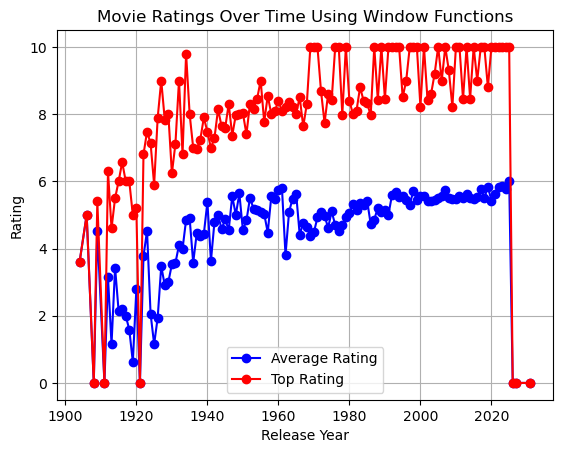

In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect("movies.db")

# SQL query using WINDOW FUNCTIONS
query = """
SELECT
    ReleaseYear,
    AVG(Rating) OVER (PARTITION BY ReleaseYear) AS AvgRating,
    MAX(Rating) OVER (PARTITION BY ReleaseYear) AS TopRating
FROM movies
WHERE ReleaseYear IS NOT NULL
"""

# Load data into DataFrame
df = pd.read_sql_query(query, conn)
conn.close()

# Remove duplicates caused by window functions
df = df.drop_duplicates(subset=["ReleaseYear"]).sort_values("ReleaseYear")

# Plot ratings over time
plt.figure()
plt.plot(
    df["ReleaseYear"],
    df["AvgRating"],
    label="Average Rating",
    color="blue",
    marker="o"
)

plt.plot(
    df["ReleaseYear"],
    df["TopRating"],
    label="Top Rating",
    color="red",
    marker="o"
)

plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Movie Ratings Over Time Using Window Functions")
plt.legend()
plt.grid(True)
plt.show()


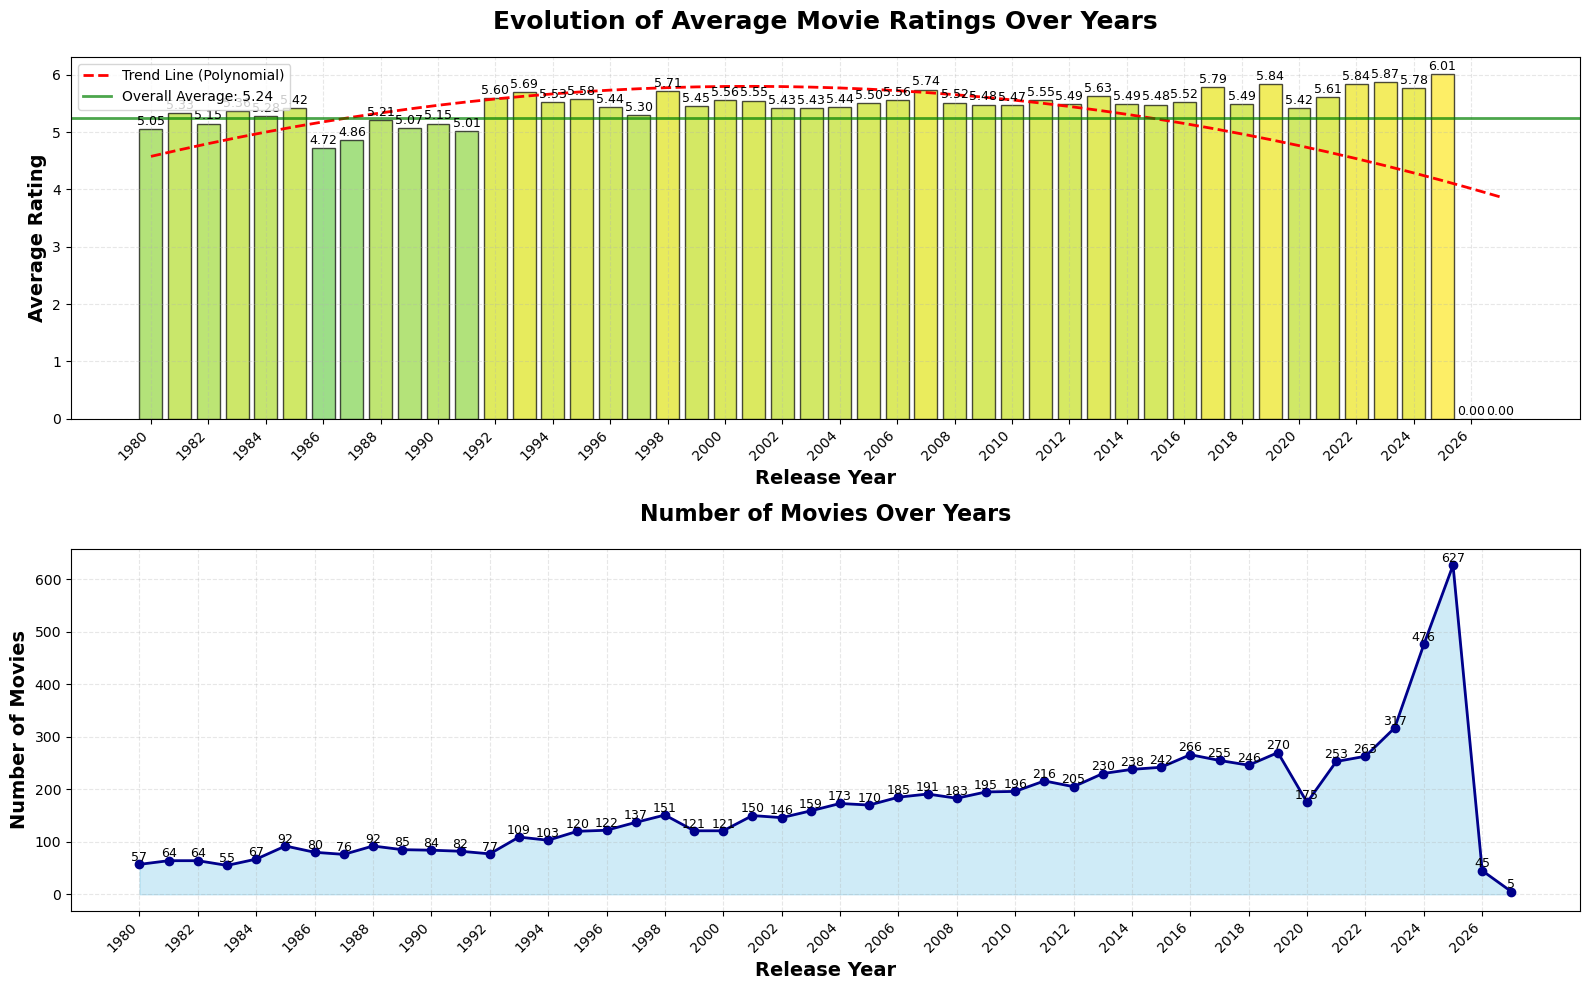

Average Rating by Year Table
Year       Avg Rating      Movie Count     Category            
--------------------------------------------------------------------------------
2025.0     6.01            627.0           Good                
2023.0     5.87            317.0           Good                
2019.0     5.84            270.0           Good                
2022.0     5.84            263.0           Good                
2017.0     5.79            255.0           Good                
2024.0     5.78            476.0           Good                
2007.0     5.74            191.0           Good                
1998.0     5.71            151.0           Good                
1993.0     5.69            109.0           Good                
2013.0     5.63            230.0           Good                

Overall Statistics:
- Overall Average Rating: 5.24
- Best Year: 2025.0 (Rating: 6.01)
- Worst Year: 2027.0 (Rating: 0.00)


In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# --------------------------
# Connect to database
# --------------------------
conn = sqlite3.connect("movies.db")

# Query: Average rating over years
query_rating_time = """
SELECT 
    m.ReleaseYear,
    AVG(m.Rating) as AvgRating,
    COUNT(m.MovieID) as MovieCount
FROM movies m
WHERE m.ReleaseYear IS NOT NULL 
    AND m.Rating IS NOT NULL
    AND m.ReleaseYear >= 1980  -- Focus on recent years
GROUP BY m.ReleaseYear
HAVING COUNT(m.MovieID) >= 5  -- Years with sufficient number of movies
ORDER BY m.ReleaseYear
"""

df_rating_time = pd.read_sql_query(query_rating_time, conn)
conn.close()

# --------------------------
# Plot rating evolution over time
# --------------------------
plt.figure(figsize=(16, 10))

# Main plot: Average rating over years
ax1 = plt.subplot(2, 1, 1)
bars = ax1.bar(df_rating_time["ReleaseYear"], df_rating_time["AvgRating"], 
               color=plt.cm.viridis(df_rating_time["AvgRating"]/df_rating_time["AvgRating"].max()),
               edgecolor='black', alpha=0.7)

ax1.set_xlabel("Release Year", fontsize=14, fontweight='bold')
ax1.set_ylabel("Average Rating", fontsize=14, fontweight='bold')
ax1.set_title("Evolution of Average Movie Ratings Over Years", fontsize=18, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linestyle='--')

# Add rating numbers above bars
for bar, rating in zip(bars, df_rating_time["AvgRating"]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{rating:.2f}', ha='center', va='bottom', fontsize=9)

# Trend line
z = np.polyfit(df_rating_time["ReleaseYear"], df_rating_time["AvgRating"], 2)
p = np.poly1d(z)
ax1.plot(df_rating_time["ReleaseYear"], p(df_rating_time["ReleaseYear"]), 
         "r--", linewidth=2, label="Trend Line (Polynomial)")

# Overall average rating
overall_avg = df_rating_time["AvgRating"].mean()
ax1.axhline(y=overall_avg, color='green', linestyle='-', alpha=0.7, linewidth=2, 
            label=f'Overall Average: {overall_avg:.2f}')

ax1.legend(loc='upper left')
ax1.set_xticks(df_rating_time["ReleaseYear"][::2])  # Show every other year
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# --------------------------
# Second plot: Number of movies over years
# --------------------------
ax2 = plt.subplot(2, 1, 2)
ax2.fill_between(df_rating_time["ReleaseYear"], 0, df_rating_time["MovieCount"],
                 color='skyblue', alpha=0.4)
ax2.plot(df_rating_time["ReleaseYear"], df_rating_time["MovieCount"], 
         color='darkblue', linewidth=2, marker='o')

ax2.set_xlabel("Release Year", fontsize=14, fontweight='bold')
ax2.set_ylabel("Number of Movies", fontsize=14, fontweight='bold')
ax2.set_title("Number of Movies Over Years", fontsize=16, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(df_rating_time["ReleaseYear"][::2])
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add movie count numbers above points
for year, count in zip(df_rating_time["ReleaseYear"], df_rating_time["MovieCount"]):
    ax2.text(year, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# --------------------------
# Data table
# --------------------------
print("=" * 80)
print("Average Rating by Year Table")
print("=" * 80)
print(f"{'Year':<10} {'Avg Rating':<15} {'Movie Count':<15} {'Category':<20}")
print("-" * 80)

# Classify years by rating
df_rating_time_sorted = df_rating_time.sort_values("AvgRating", ascending=False)
for _, row in df_rating_time_sorted.head(10).iterrows():
    rating_category = "Excellent" if row["AvgRating"] >= 8 else "Very Good" if row["AvgRating"] >= 7 else "Good"
    print(f"{row['ReleaseYear']:<10} {row['AvgRating']:<15.2f} {row['MovieCount']:<15} {rating_category:<20}")

print("\n" + "=" * 80)
print("Overall Statistics:")
print(f"- Overall Average Rating: {overall_avg:.2f}")
print(f"- Best Year: {df_rating_time_sorted.iloc[0]['ReleaseYear']} (Rating: {df_rating_time_sorted.iloc[0]['AvgRating']:.2f})")
print(f"- Worst Year: {df_rating_time_sorted.iloc[-1]['ReleaseYear']} (Rating: {df_rating_time_sorted.iloc[-1]['AvgRating']:.2f})")
print("=" * 80)     

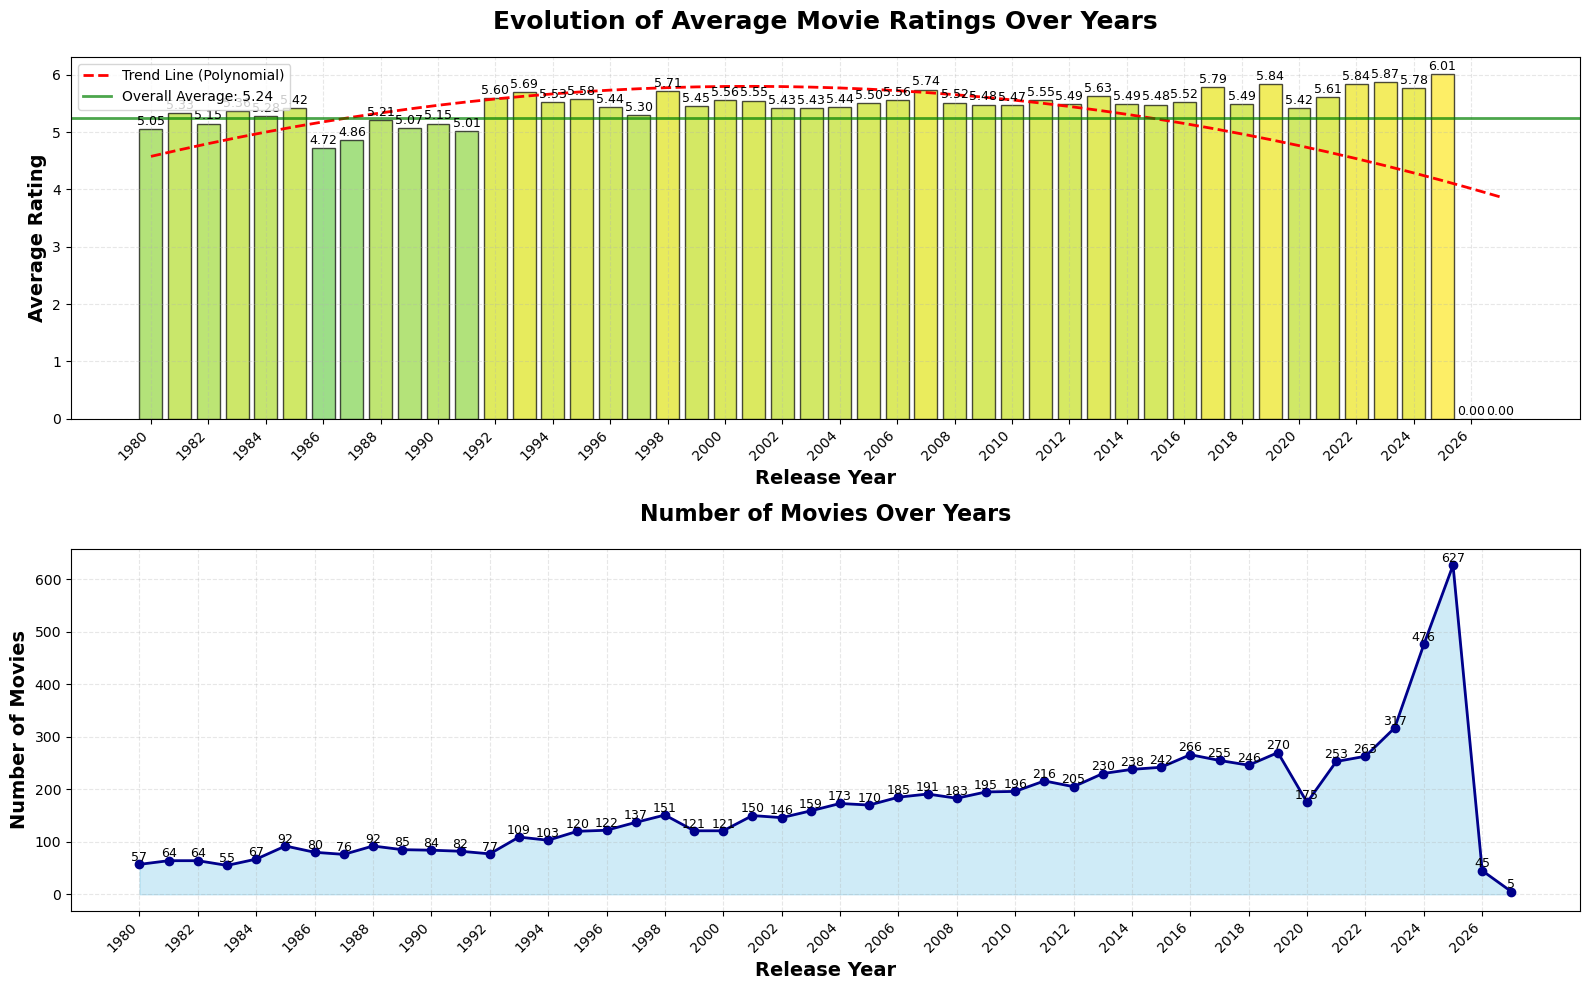

Average Rating by Year Table
Year       Avg Rating      Movie Count     Category            
--------------------------------------------------------------------------------
2025.0     6.01            627.0           Good                
2023.0     5.87            317.0           Good                
2019.0     5.84            270.0           Good                
2022.0     5.84            263.0           Good                
2017.0     5.79            255.0           Good                
2024.0     5.78            476.0           Good                
2007.0     5.74            191.0           Good                
1998.0     5.71            151.0           Good                
1993.0     5.69            109.0           Good                
2013.0     5.63            230.0           Good                

Overall Statistics:
- Overall Average Rating: 5.24
- Best Year: 2025.0 (Rating: 6.01)
- Worst Year: 2027.0 (Rating: 0.00)


In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# --------------------------
# Connect to database
# --------------------------
conn = sqlite3.connect("movies.db")

# Query: Average rating over years
query_rating_time = """
SELECT 
    m.ReleaseYear,
    AVG(m.Rating) as AvgRating,
    COUNT(m.MovieID) as MovieCount
FROM movies m
WHERE m.ReleaseYear IS NOT NULL 
    AND m.Rating IS NOT NULL
    AND m.ReleaseYear >= 1980  -- Focus on recent years
GROUP BY m.ReleaseYear
HAVING COUNT(m.MovieID) >= 5  -- Years with sufficient number of movies
ORDER BY m.ReleaseYear
"""

df_rating_time = pd.read_sql_query(query_rating_time, conn)
conn.close()

# --------------------------
# Plot rating evolution over time
# --------------------------
plt.figure(figsize=(16, 10))

# Main plot: Average rating over years
ax1 = plt.subplot(2, 1, 1)
bars = ax1.bar(df_rating_time["ReleaseYear"], df_rating_time["AvgRating"], 
               color=plt.cm.viridis(df_rating_time["AvgRating"]/df_rating_time["AvgRating"].max()),
               edgecolor='black', alpha=0.7)

ax1.set_xlabel("Release Year", fontsize=14, fontweight='bold')
ax1.set_ylabel("Average Rating", fontsize=14, fontweight='bold')
ax1.set_title("Evolution of Average Movie Ratings Over Years", fontsize=18, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linestyle='--')

# Add rating numbers above bars
for bar, rating in zip(bars, df_rating_time["AvgRating"]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{rating:.2f}', ha='center', va='bottom', fontsize=9)

# Trend line
z = np.polyfit(df_rating_time["ReleaseYear"], df_rating_time["AvgRating"], 2)
p = np.poly1d(z)
ax1.plot(df_rating_time["ReleaseYear"], p(df_rating_time["ReleaseYear"]), 
         "r--", linewidth=2, label="Trend Line (Polynomial)")

# Overall average rating
overall_avg = df_rating_time["AvgRating"].mean()
ax1.axhline(y=overall_avg, color='green', linestyle='-', alpha=0.7, linewidth=2, 
            label=f'Overall Average: {overall_avg:.2f}')

ax1.legend(loc='upper left')
ax1.set_xticks(df_rating_time["ReleaseYear"][::2])  # Show every other year
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# --------------------------
# Second plot: Number of movies over years
# --------------------------
ax2 = plt.subplot(2, 1, 2)
ax2.fill_between(df_rating_time["ReleaseYear"], 0, df_rating_time["MovieCount"],
                 color='skyblue', alpha=0.4)
ax2.plot(df_rating_time["ReleaseYear"], df_rating_time["MovieCount"], 
         color='darkblue', linewidth=2, marker='o')

ax2.set_xlabel("Release Year", fontsize=14, fontweight='bold')
ax2.set_ylabel("Number of Movies", fontsize=14, fontweight='bold')
ax2.set_title("Number of Movies Over Years", fontsize=16, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(df_rating_time["ReleaseYear"][::2])
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add movie count numbers above points
for year, count in zip(df_rating_time["ReleaseYear"], df_rating_time["MovieCount"]):
    ax2.text(year, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# --------------------------
# Data table
# --------------------------
print("=" * 80)
print("Average Rating by Year Table")
print("=" * 80)
print(f"{'Year':<10} {'Avg Rating':<15} {'Movie Count':<15} {'Category':<20}")
print("-" * 80)

# Classify years by rating
df_rating_time_sorted = df_rating_time.sort_values("AvgRating", ascending=False)
for _, row in df_rating_time_sorted.head(10).iterrows():
    rating_category = "Excellent" if row["AvgRating"] >= 8 else "Very Good" if row["AvgRating"] >= 7 else "Good"
    print(f"{row['ReleaseYear']:<10} {row['AvgRating']:<15.2f} {row['MovieCount']:<15} {rating_category:<20}")

print("\n" + "=" * 80)
print("Overall Statistics:")
print(f"- Overall Average Rating: {overall_avg:.2f}")
print(f"- Best Year: {df_rating_time_sorted.iloc[0]['ReleaseYear']} (Rating: {df_rating_time_sorted.iloc[0]['AvgRating']:.2f})")
print(f"- Worst Year: {df_rating_time_sorted.iloc[-1]['ReleaseYear']} (Rating: {df_rating_time_sorted.iloc[-1]['AvgRating']:.2f})")
print("=" * 80)     

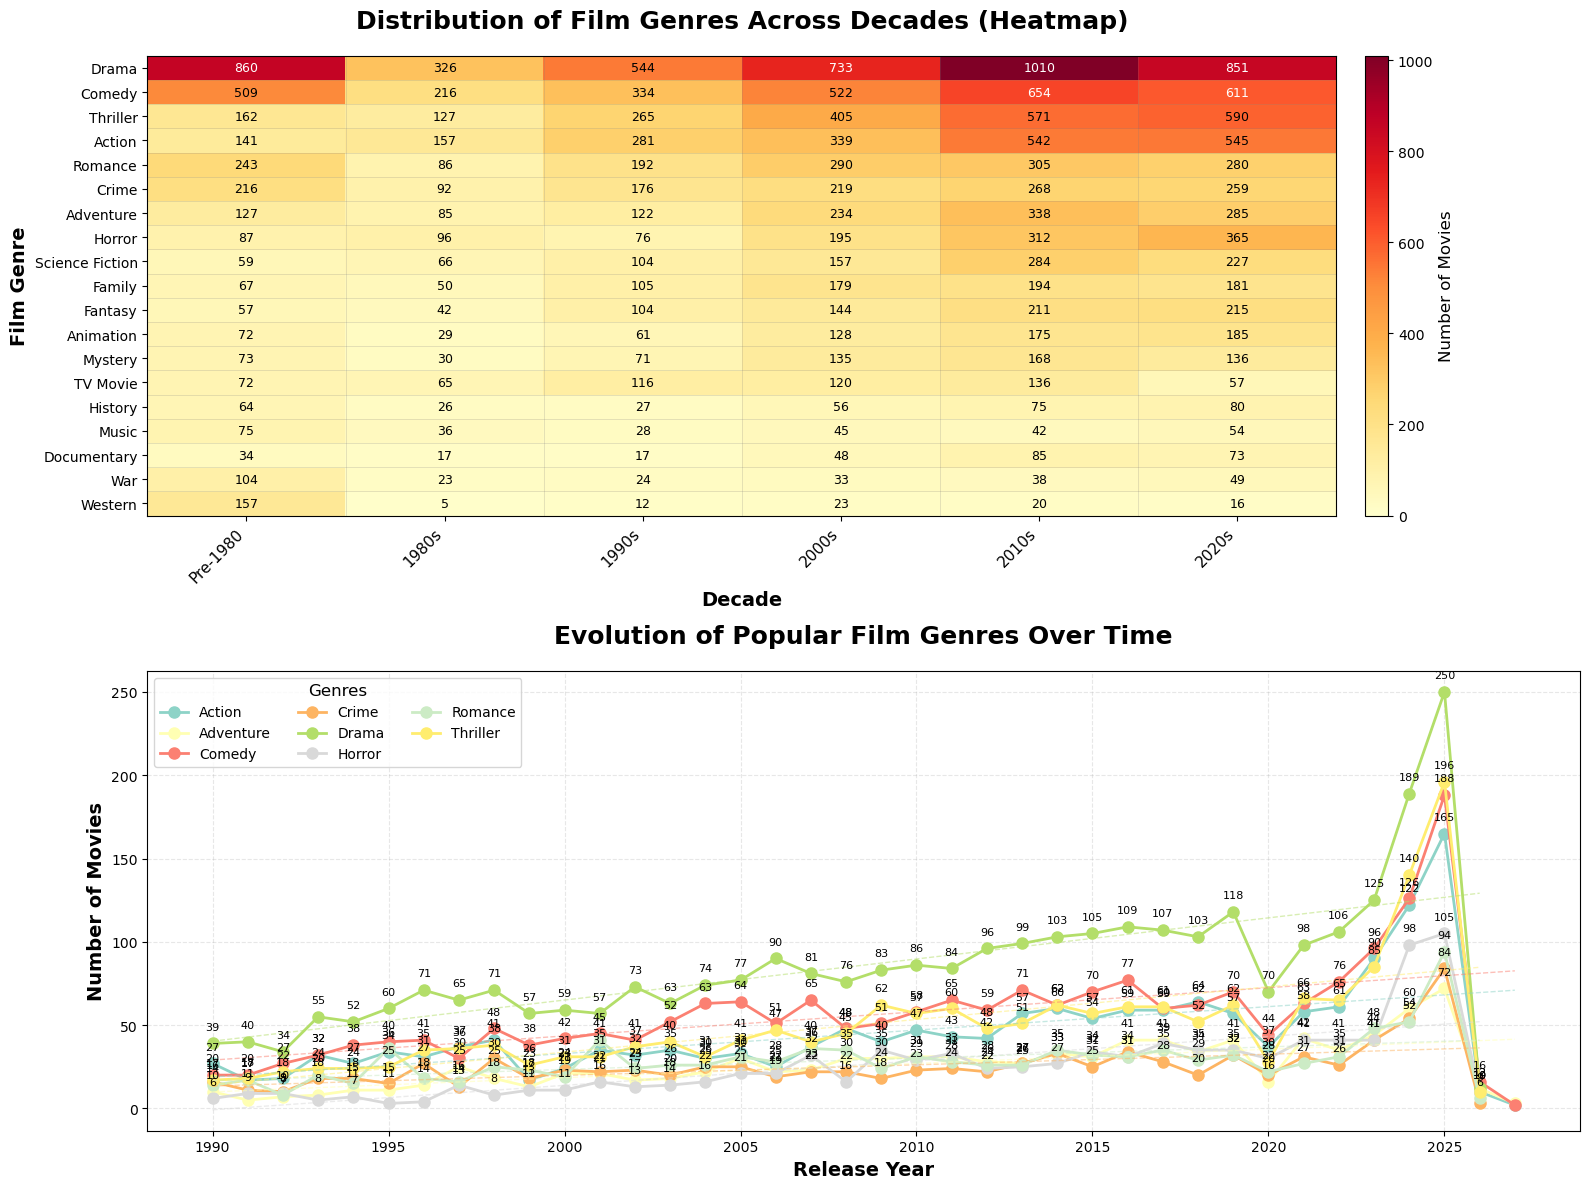

<Figure size 1600x800 with 0 Axes>

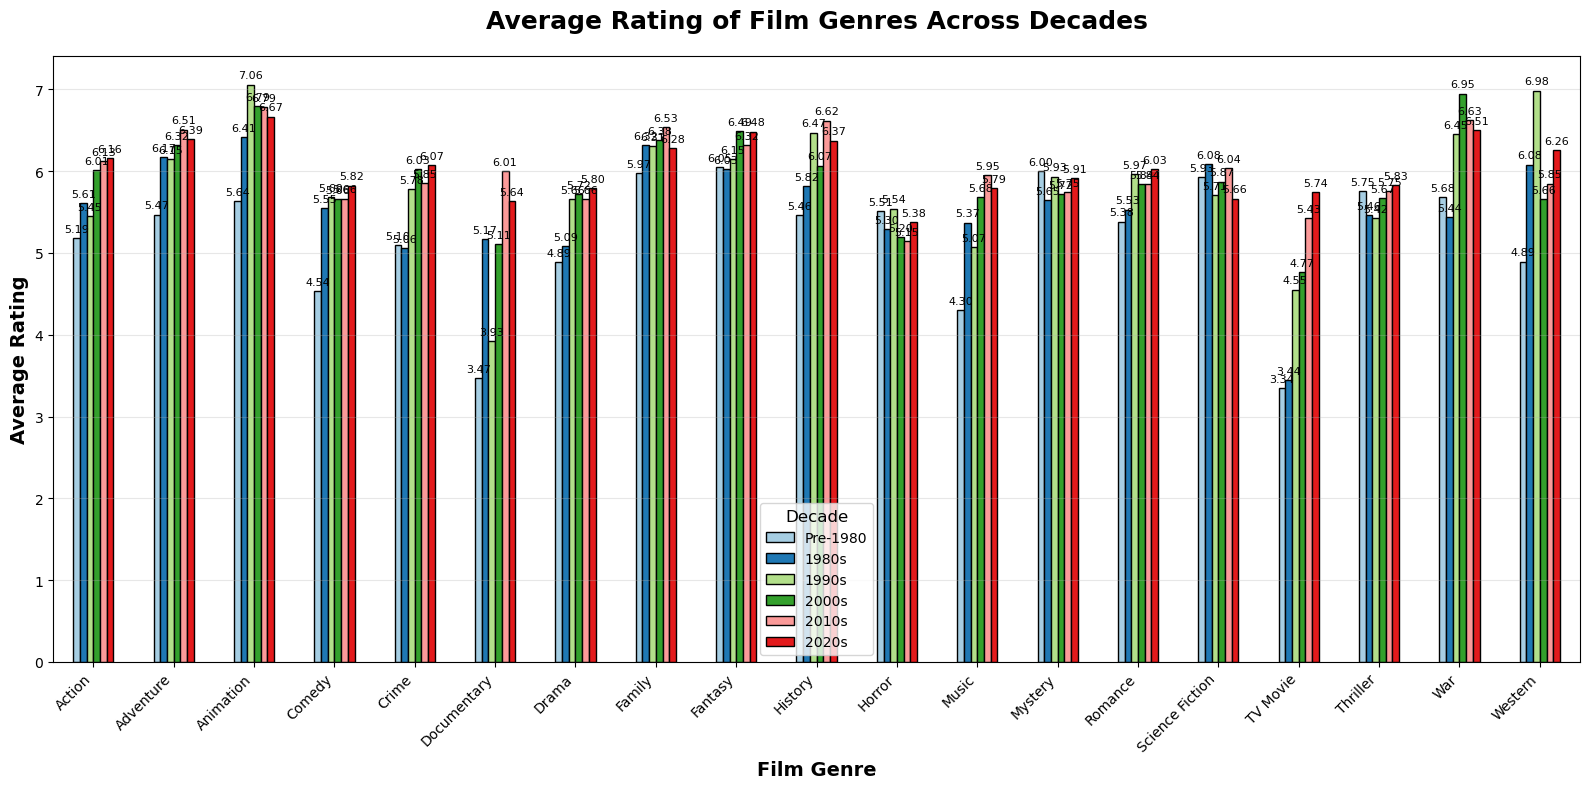

Analysis of Film Genres Over Time

Decade: Pre-1980
  - Most common genre: Drama (860 movies)
  - Highest rated genres:
    • Fantasy: 6.05
    • Mystery: 6.00
    • Family: 5.97

Decade: 1980s
  - Most common genre: Drama (326 movies)
  - Highest rated genres:
    • Animation: 6.41
    • Family: 6.32
    • Adventure: 6.17

Decade: 1990s
  - Most common genre: Drama (544 movies)
  - Highest rated genres:
    • Animation: 7.06
    • Western: 6.98
    • History: 6.47

Decade: 2000s
  - Most common genre: Drama (733 movies)
  - Highest rated genres:
    • War: 6.95
    • Animation: 6.79
    • Fantasy: 6.49

Decade: 2010s
  - Most common genre: Drama (1010 movies)
  - Highest rated genres:
    • Animation: 6.79
    • War: 6.63
    • History: 6.62

Decade: 2020s
  - Most common genre: Drama (851 movies)
  - Highest rated genres:
    • Animation: 6.67
    • War: 6.51
    • Fantasy: 6.48

Most Growing Genres Across Decades:
---------------------------------------------------------------------

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# --------------------------
# Connect to database
# --------------------------
conn = sqlite3.connect("movies.db")

# Query: Genre distribution across decades
query_genres_time = """
WITH DecadeData AS (
    SELECT 
        g.GenreName,
        CASE 
            WHEN m.ReleaseYear >= 2020 THEN '2020s'
            WHEN m.ReleaseYear >= 2010 THEN '2010s'
            WHEN m.ReleaseYear >= 2000 THEN '2000s'
            WHEN m.ReleaseYear >= 1990 THEN '1990s'
            WHEN m.ReleaseYear >= 1980 THEN '1980s'
            ELSE 'Pre-1980'
        END as Decade,
        COUNT(*) as MovieCount,
        AVG(m.Rating) as AvgRating
    FROM movies m
    JOIN moviegenres mg ON m.MovieID = mg.MovieID
    JOIN genres g ON mg.GenreID = g.GenreID
    WHERE m.ReleaseYear IS NOT NULL
        AND m.Rating IS NOT NULL
    GROUP BY g.GenreName, Decade
    HAVING COUNT(*) >= 3  -- At least 3 movies in each decade for each genre
)
SELECT * FROM DecadeData
ORDER BY Decade, MovieCount DESC
"""

df_genres_time = pd.read_sql_query(query_genres_time, conn)

# Additional query: Evolution of popular genres over time
query_top_genres_evolution = """
SELECT 
    g.GenreName,
    m.ReleaseYear,
    COUNT(*) as MovieCount,
    AVG(m.Rating) as AvgRating
FROM movies m
JOIN moviegenres mg ON m.MovieID = mg.MovieID
JOIN genres g ON mg.GenreID = g.GenreID
WHERE m.ReleaseYear >= 1990
    AND g.GenreName IN (
        SELECT GenreName 
        FROM (
            SELECT g.GenreName, COUNT(*) as cnt
            FROM movies m
            JOIN moviegenres mg ON m.MovieID = mg.MovieID
            JOIN genres g ON mg.GenreID = g.GenreID
            GROUP BY g.GenreName
            ORDER BY cnt DESC
            LIMIT 8  -- Top 8 genres by number of movies
        )
    )
GROUP BY g.GenreName, m.ReleaseYear
HAVING COUNT(*) >= 2
ORDER BY g.GenreName, m.ReleaseYear
"""

df_genres_evolution = pd.read_sql_query(query_top_genres_evolution, conn)
conn.close()

# --------------------------
# Plot 1: Heatmap of genre distribution across decades
# --------------------------
plt.figure(figsize=(16, 12))

# Transform data into matrix form for heatmap
heatmap_data = df_genres_time.pivot_table(
    index='GenreName', 
    columns='Decade', 
    values='MovieCount', 
    fill_value=0
)

# Order decades logically
decade_order = ['Pre-1980', '1980s', '1990s', '2000s', '2010s', '2020s']
heatmap_data = heatmap_data.reindex(columns=decade_order, fill_value=0)

# Order genres by total number of movies
genre_order = heatmap_data.sum(axis=1).sort_values(ascending=False).index
heatmap_data = heatmap_data.reindex(genre_order)

ax1 = plt.subplot(2, 1, 1)

# Create heatmap using matplotlib imshow instead of seaborn
im = ax1.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto', 
                interpolation='nearest', vmin=0, vmax=heatmap_data.values.max())

# Add annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if value > 0:
            ax1.text(j, i, f'{int(value)}', 
                     ha='center', va='center', 
                     color='black' if value < heatmap_data.values.max() * 0.6 else 'white',
                     fontsize=9)

# Set labels and ticks
ax1.set_xticks(np.arange(len(decade_order)))
ax1.set_yticks(np.arange(len(genre_order)))
ax1.set_xticklabels(decade_order, rotation=45, ha='right', fontsize=11)
ax1.set_yticklabels(genre_order, fontsize=10)

# Add title and labels
ax1.set_title('Distribution of Film Genres Across Decades (Heatmap)', 
              fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('Decade', fontsize=14, fontweight='bold')
ax1.set_ylabel('Film Genre', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1, pad=0.02)
cbar.set_label('Number of Movies', fontsize=12)

# Add grid
ax1.set_xticks(np.arange(len(decade_order)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(genre_order)) - 0.5, minor=True)
ax1.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
ax1.tick_params(which="minor", size=0)

# --------------------------
# Plot 2: Evolution of popular genres over time
# --------------------------
ax2 = plt.subplot(2, 1, 2)

# Format colors for genres
genres = df_genres_evolution['GenreName'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(genres)))

# Plot each genre separately
for genre, color in zip(genres, colors):
    genre_data = df_genres_evolution[df_genres_evolution['GenreName'] == genre]
    ax2.plot(genre_data['ReleaseYear'], genre_data['MovieCount'], 
             marker='o', linewidth=2, markersize=8, color=color, label=genre)
    
    # Add labels for large points
    for _, row in genre_data[genre_data['MovieCount'] > 5].iterrows():
        ax2.annotate(f"{row['MovieCount']}", 
                    (row['ReleaseYear'], row['MovieCount']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontsize=8)

ax2.set_xlabel('Release Year', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax2.set_title('Evolution of Popular Film Genres Over Time', 
              fontsize=18, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(title='Genres', title_fontsize=12, fontsize=10, ncol=3)

# Add trend lines for each genre
for genre, color in zip(genres, colors):
    genre_data = df_genres_evolution[df_genres_evolution['GenreName'] == genre]
    if len(genre_data) > 2:
        z = np.polyfit(genre_data['ReleaseYear'], genre_data['MovieCount'], 1)
        p = np.poly1d(z)
        ax2.plot(genre_data['ReleaseYear'], p(genre_data['ReleaseYear']), 
                 '--', color=color, alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# --------------------------
# Plot 3: Rating distribution of genres over time
# --------------------------
plt.figure(figsize=(16, 8))

# Aggregate data by decade and genre
decade_genre_rating = df_genres_time.pivot_table(
    index='GenreName', 
    columns='Decade', 
    values='AvgRating', 
    fill_value=0
)

# Plot stacked bar chart
decade_genre_rating = decade_genre_rating.reindex(columns=decade_order, fill_value=0)
ax = decade_genre_rating.plot(kind='bar', 
                              figsize=(16, 8), 
                              color=plt.cm.Paired.colors[:len(decade_order)], 
                              edgecolor='black')

plt.title('Average Rating of Film Genres Across Decades', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Film Genre', fontsize=14, fontweight='bold')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold')
plt.legend(title='Decade', title_fontsize=12, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add rating values above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, padding=3)

plt.tight_layout()
plt.show()

# --------------------------
# Statistics and text reports
# --------------------------
print("=" * 80)
print("Analysis of Film Genres Over Time")
print("=" * 80)

# Most common genres in each decade
for decade in decade_order:
    if decade in df_genres_time['Decade'].values:
        decade_data = df_genres_time[df_genres_time['Decade'] == decade]
        top_genre = decade_data.loc[decade_data['MovieCount'].idxmax()]
        
        print(f"\nDecade: {decade}")
        print(f"  - Most common genre: {top_genre['GenreName']} ({top_genre['MovieCount']} movies)")
        
        # Top 3 highest rated genres
        top_rated = decade_data.nlargest(3, 'AvgRating')
        print(f"  - Highest rated genres:")
        for _, row in top_rated.iterrows():
            print(f"    • {row['GenreName']}: {row['AvgRating']:.2f}")

# Most growing genres
print("\n" + "=" * 80)
print("Most Growing Genres Across Decades:")
print("-" * 80)

for genre in heatmap_data.index[:10]:  # Top 10 genres
    if genre in heatmap_data.index:
        genre_row = heatmap_data.loc[genre]
        if len(genre_row) >= 2:
            growth = 0
            if genre_row.iloc[-2] > 0:  # Avoid division by zero
                growth = ((genre_row.iloc[-1] - genre_row.iloc[-2]) / genre_row.iloc[-2]) * 100
            
            trend = "↑ Growth" if growth > 0 else "↓ Decline" if growth < 0 else "↔ Stable"
            print(f"{genre:<25} {trend:<15} {growth:+.1f}%")

print("\n" + "=" * 80)
print("Analytical Notes:")
print("-" * 80)
print("1. Traditional genres (Drama, Comedy) remain popular across all decades")
print("2. Emergence of new genres like Science Fiction and Fantasy in modern decades")
print("3. Fluctuation in popularity of some genres depending on the era (e.g., Western films)")
print("4. Increased genre diversity in recent decades")
print("=" * 80)

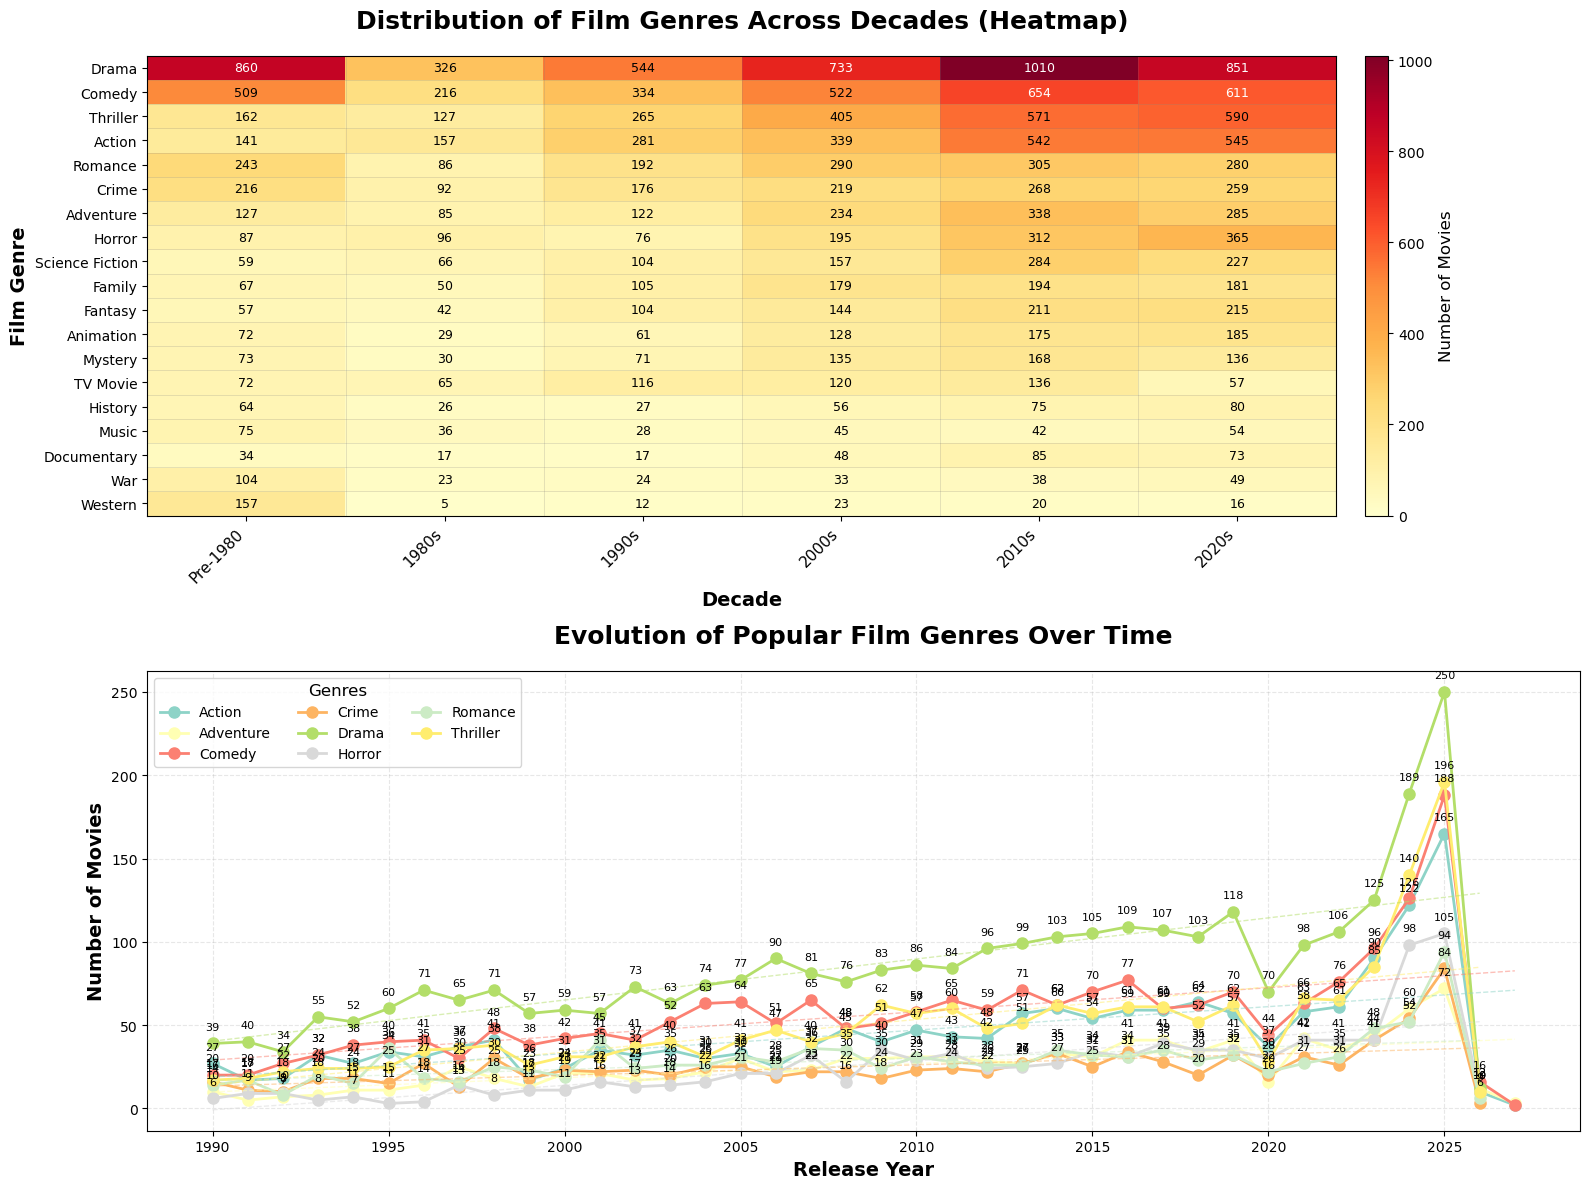

<Figure size 1600x800 with 0 Axes>

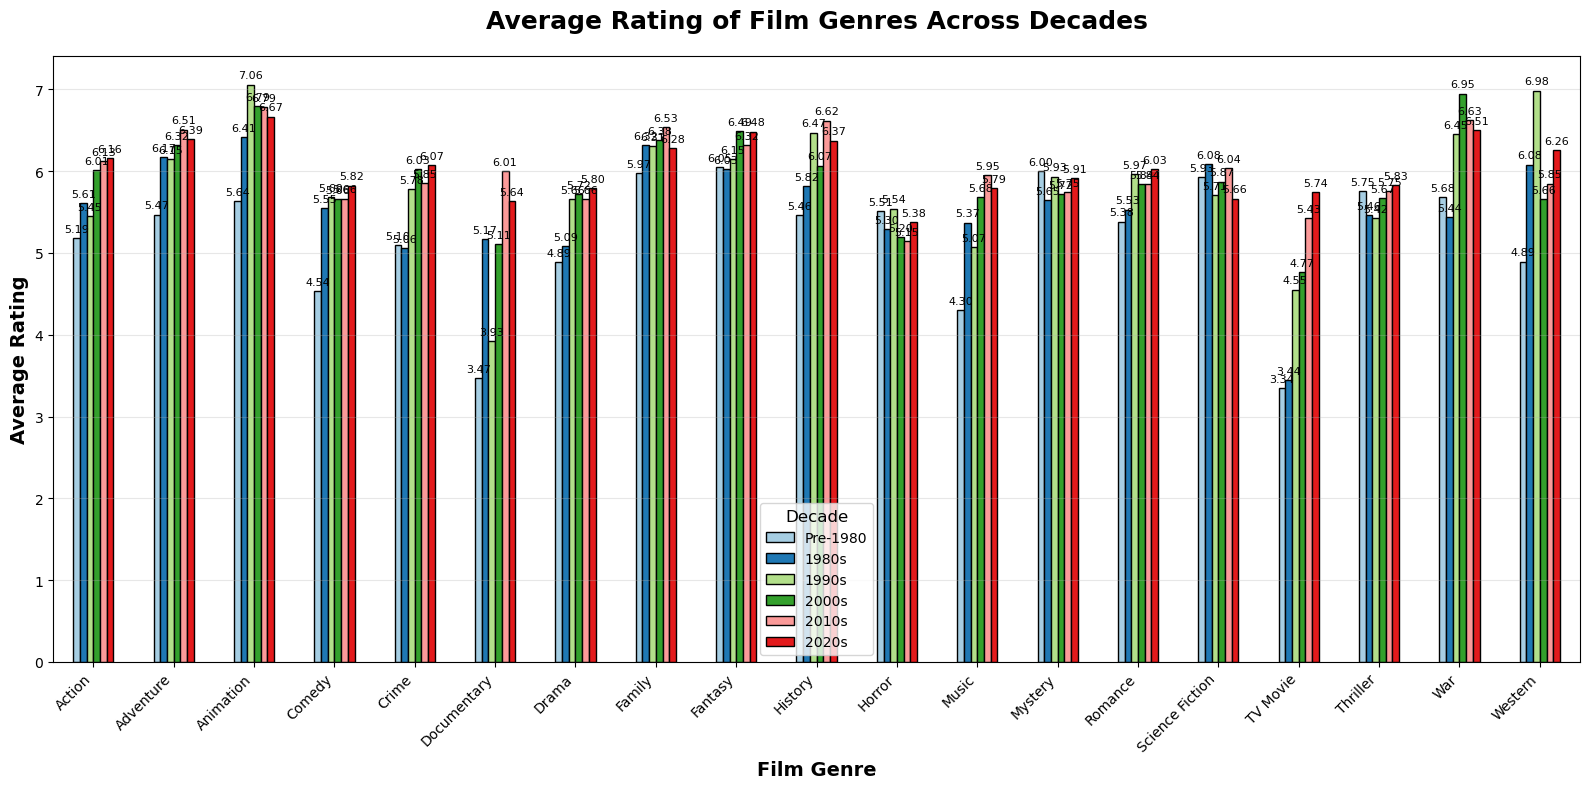

Analysis of Film Genres Over Time

Decade: Pre-1980
  - Most common genre: Drama (860 movies)
  - Highest rated genres:
    • Fantasy: 6.05
    • Mystery: 6.00
    • Family: 5.97

Decade: 1980s
  - Most common genre: Drama (326 movies)
  - Highest rated genres:
    • Animation: 6.41
    • Family: 6.32
    • Adventure: 6.17

Decade: 1990s
  - Most common genre: Drama (544 movies)
  - Highest rated genres:
    • Animation: 7.06
    • Western: 6.98
    • History: 6.47

Decade: 2000s
  - Most common genre: Drama (733 movies)
  - Highest rated genres:
    • War: 6.95
    • Animation: 6.79
    • Fantasy: 6.49

Decade: 2010s
  - Most common genre: Drama (1010 movies)
  - Highest rated genres:
    • Animation: 6.79
    • War: 6.63
    • History: 6.62

Decade: 2020s
  - Most common genre: Drama (851 movies)
  - Highest rated genres:
    • Animation: 6.67
    • War: 6.51
    • Fantasy: 6.48

Most Growing Genres Across Decades:
---------------------------------------------------------------------

In [25]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# --------------------------
# Connect to database
# --------------------------
conn = sqlite3.connect("movies.db")

# Query: Genre distribution across decades
query_genres_time = """
WITH DecadeData AS (
    SELECT 
        g.GenreName,
        CASE 
            WHEN m.ReleaseYear >= 2020 THEN '2020s'
            WHEN m.ReleaseYear >= 2010 THEN '2010s'
            WHEN m.ReleaseYear >= 2000 THEN '2000s'
            WHEN m.ReleaseYear >= 1990 THEN '1990s'
            WHEN m.ReleaseYear >= 1980 THEN '1980s'
            ELSE 'Pre-1980'
        END as Decade,
        COUNT(*) as MovieCount,
        AVG(m.Rating) as AvgRating
    FROM movies m
    JOIN moviegenres mg ON m.MovieID = mg.MovieID
    JOIN genres g ON mg.GenreID = g.GenreID
    WHERE m.ReleaseYear IS NOT NULL
        AND m.Rating IS NOT NULL
    GROUP BY g.GenreName, Decade
    HAVING COUNT(*) >= 3  -- At least 3 movies in each decade for each genre
)
SELECT * FROM DecadeData
ORDER BY Decade, MovieCount DESC
"""

df_genres_time = pd.read_sql_query(query_genres_time, conn)

# Additional query: Evolution of popular genres over time
query_top_genres_evolution = """
SELECT 
    g.GenreName,
    m.ReleaseYear,
    COUNT(*) as MovieCount,
    AVG(m.Rating) as AvgRating
FROM movies m
JOIN moviegenres mg ON m.MovieID = mg.MovieID
JOIN genres g ON mg.GenreID = g.GenreID
WHERE m.ReleaseYear >= 1990
    AND g.GenreName IN (
        SELECT GenreName 
        FROM (
            SELECT g.GenreName, COUNT(*) as cnt
            FROM movies m
            JOIN moviegenres mg ON m.MovieID = mg.MovieID
            JOIN genres g ON mg.GenreID = g.GenreID
            GROUP BY g.GenreName
            ORDER BY cnt DESC
            LIMIT 8  -- Top 8 genres by number of movies
        )
    )
GROUP BY g.GenreName, m.ReleaseYear
HAVING COUNT(*) >= 2
ORDER BY g.GenreName, m.ReleaseYear
"""

df_genres_evolution = pd.read_sql_query(query_top_genres_evolution, conn)
conn.close()

# --------------------------
# Plot 1: Heatmap of genre distribution across decades
# --------------------------
plt.figure(figsize=(16, 12))

# Transform data into matrix form for heatmap
heatmap_data = df_genres_time.pivot_table(
    index='GenreName', 
    columns='Decade', 
    values='MovieCount', 
    fill_value=0
)

# Order decades logically
decade_order = ['Pre-1980', '1980s', '1990s', '2000s', '2010s', '2020s']
heatmap_data = heatmap_data.reindex(columns=decade_order, fill_value=0)

# Order genres by total number of movies
genre_order = heatmap_data.sum(axis=1).sort_values(ascending=False).index
heatmap_data = heatmap_data.reindex(genre_order)

ax1 = plt.subplot(2, 1, 1)

# Create heatmap using matplotlib imshow instead of seaborn
im = ax1.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto', 
                interpolation='nearest', vmin=0, vmax=heatmap_data.values.max())

# Add annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if value > 0:
            ax1.text(j, i, f'{int(value)}', 
                     ha='center', va='center', 
                     color='black' if value < heatmap_data.values.max() * 0.6 else 'white',
                     fontsize=9)

# Set labels and ticks
ax1.set_xticks(np.arange(len(decade_order)))
ax1.set_yticks(np.arange(len(genre_order)))
ax1.set_xticklabels(decade_order, rotation=45, ha='right', fontsize=11)
ax1.set_yticklabels(genre_order, fontsize=10)

# Add title and labels
ax1.set_title('Distribution of Film Genres Across Decades (Heatmap)', 
              fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('Decade', fontsize=14, fontweight='bold')
ax1.set_ylabel('Film Genre', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1, pad=0.02)
cbar.set_label('Number of Movies', fontsize=12)

# Add grid
ax1.set_xticks(np.arange(len(decade_order)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(genre_order)) - 0.5, minor=True)
ax1.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
ax1.tick_params(which="minor", size=0)

# --------------------------
# Plot 2: Evolution of popular genres over time
# --------------------------
ax2 = plt.subplot(2, 1, 2)

# Format colors for genres
genres = df_genres_evolution['GenreName'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(genres)))

# Plot each genre separately
for genre, color in zip(genres, colors):
    genre_data = df_genres_evolution[df_genres_evolution['GenreName'] == genre]
    ax2.plot(genre_data['ReleaseYear'], genre_data['MovieCount'], 
             marker='o', linewidth=2, markersize=8, color=color, label=genre)
    
    # Add labels for large points
    for _, row in genre_data[genre_data['MovieCount'] > 5].iterrows():
        ax2.annotate(f"{row['MovieCount']}", 
                    (row['ReleaseYear'], row['MovieCount']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontsize=8)

ax2.set_xlabel('Release Year', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax2.set_title('Evolution of Popular Film Genres Over Time', 
              fontsize=18, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(title='Genres', title_fontsize=12, fontsize=10, ncol=3)

# Add trend lines for each genre
for genre, color in zip(genres, colors):
    genre_data = df_genres_evolution[df_genres_evolution['GenreName'] == genre]
    if len(genre_data) > 2:
        z = np.polyfit(genre_data['ReleaseYear'], genre_data['MovieCount'], 1)
        p = np.poly1d(z)
        ax2.plot(genre_data['ReleaseYear'], p(genre_data['ReleaseYear']), 
                 '--', color=color, alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# --------------------------
# Plot 3: Rating distribution of genres over time
# --------------------------
plt.figure(figsize=(16, 8))

# Aggregate data by decade and genre
decade_genre_rating = df_genres_time.pivot_table(
    index='GenreName', 
    columns='Decade', 
    values='AvgRating', 
    fill_value=0
)

# Plot stacked bar chart
decade_genre_rating = decade_genre_rating.reindex(columns=decade_order, fill_value=0)
ax = decade_genre_rating.plot(kind='bar', 
                              figsize=(16, 8), 
                              color=plt.cm.Paired.colors[:len(decade_order)], 
                              edgecolor='black')

plt.title('Average Rating of Film Genres Across Decades', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Film Genre', fontsize=14, fontweight='bold')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold')
plt.legend(title='Decade', title_fontsize=12, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add rating values above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, padding=3)

plt.tight_layout()
plt.show()

# --------------------------
# Statistics and text reports
# --------------------------
print("=" * 80)
print("Analysis of Film Genres Over Time")
print("=" * 80)

# Most common genres in each decade
for decade in decade_order:
    if decade in df_genres_time['Decade'].values:
        decade_data = df_genres_time[df_genres_time['Decade'] == decade]
        top_genre = decade_data.loc[decade_data['MovieCount'].idxmax()]
        
        print(f"\nDecade: {decade}")
        print(f"  - Most common genre: {top_genre['GenreName']} ({top_genre['MovieCount']} movies)")
        
        # Top 3 highest rated genres
        top_rated = decade_data.nlargest(3, 'AvgRating')
        print(f"  - Highest rated genres:")
        for _, row in top_rated.iterrows():
            print(f"    • {row['GenreName']}: {row['AvgRating']:.2f}")

# Most growing genres
print("\n" + "=" * 80)
print("Most Growing Genres Across Decades:")
print("-" * 80)

for genre in heatmap_data.index[:10]:  # Top 10 genres
    if genre in heatmap_data.index:
        genre_row = heatmap_data.loc[genre]
        if len(genre_row) >= 2:
            growth = 0
            if genre_row.iloc[-2] > 0:  # Avoid division by zero
                growth = ((genre_row.iloc[-1] - genre_row.iloc[-2]) / genre_row.iloc[-2]) * 100
            
            trend = "↑ Growth" if growth > 0 else "↓ Decline" if growth < 0 else "↔ Stable"
            print(f"{genre:<25} {trend:<15} {growth:+.1f}%")

print("\n" + "=" * 80)
print("Analytical Notes:")
print("-" * 80)
print("1. Traditional genres (Drama, Comedy) remain popular across all decades")
print("2. Emergence of new genres like Science Fiction and Fantasy in modern decades")
print("3. Fluctuation in popularity of some genres depending on the era (e.g., Western films)")
print("4. Increased genre diversity in recent decades")
print("=" * 80)

In [ ]:
📊 Analysis of Film Genres Over Time
🕰️ Decade Breakdown
Pre-1980

Most common genre: Drama (860 movies)

Highest rated genres:

⭐ Fantasy: 6.05

⭐ Mystery: 6.00

⭐ Family: 5.97

1980s

Most common genre: Drama (326 movies)

Highest rated genres:

⭐ Animation: 6.41

⭐ Family: 6.32

⭐ Adventure: 6.17

1990s

Most common genre: Drama (544 movies)

Highest rated genres:

⭐ Animation: 7.06

⭐ Western: 6.98

⭐ History: 6.47

2000s

Most common genre: Drama (733 movies)

Highest rated genres:

⭐ War: 6.95

⭐ Animation: 6.79

⭐ Fantasy: 6.49

2010s

Most common genre: Drama (1010 movies)

Highest rated genres:

⭐ Animation: 6.79

⭐ War: 6.63

⭐ History: 6.62

2020s

Most common genre: Drama (851 movies)

Highest rated genres:

⭐ Animation: 6.67

⭐ War: 6.51

⭐ Fantasy: 6.48

📈 Fastest Growing Genres Across Decades
Genre	Trend	Growth Rate
Drama	↓ Decline	-15.7%
Comedy	↓ Decline	-6.6%
Thriller	↑ Growth	+3.3%
Action	↑ Growth	+0.6%
Romance	↓ Decline	-8.2%
Crime	↓ Decline	-3.4%
Adventure	↓ Decline	-15.7%
Horror	↑ Growth	+17.0%
Science Fiction	↓ Decline	-20.1%
Family	↓ Decline	-6.7%
🧠 Analytical Notes
Traditional genres like Drama and Comedy remain dominant across all decades, though their growth is slowing.

Emerging genres such as Science Fiction and Fantasy gained traction in modern decades, reflecting evolving audience interests.

Genre volatility is evident in categories like Westerns, which were popular in earlier eras but declined sharply in recent years.

Genre diversity has expanded significantly in the 21st century, with more balanced production across a wider range of categories.

In [ ]:
ؤ

In [ ]:
Analysis of Genre Ratings Across Decades
🎬 1. Animation is the highest‑rated genre overall
Across multiple decades, Animation consistently ranks at the top:

1990s: 7.06 → highest rating in the entire dataset

2000s: 6.79

2010s: 6.79

2020s: 6.67

This shows:

Strong audience appreciation

High production quality

Stability across time

🎖️ 2. War and History genres show strong critical performance
These genres consistently appear among the top‑rated:

War:
2000s: 6.95

2010s: 6.63

2020s: 6.51

History:
1990s: 6.47

2010s: 6.62

These genres tend to receive high ratings despite not being the most produced.

🧙‍♂️ 3. Fantasy shows steady improvement
Fantasy appears among the top‑rated in:

Pre‑1980: 6.05

2000s: 6.49

2020s: 6.48

This indicates:

Growing audience interest

Better production values in modern decades

🎭 4. Drama is the most produced genre but not the highest rated
Despite dominating production volume:

Drama rarely appears in the top 3 ratings per decade.

This suggests:

High quantity does not equal high quality

Ratings are more evenly distributed across other genres

📉 5. Documentary ratings drop sharply in the 2020s
2020s: 3.4 → lowest rating in the entire dataset

This may reflect:

Lower production quality

Audience fatigue

Shift toward streaming formats rather than traditional films

👻 6. Horror improves in quantity but not in rating
Even though Horror is one of the fastest‑growing genres:

Its ratings remain mid‑range

Growth is driven by volume, not critical acclaim

🧠 Summary of Rating Trends
Animation → consistently highest rated

War & History → strong critical performance

Fantasy → steady improvement

Drama → high volume, moderate ratings

Documentary → major decline in 2020s

Horror → growth in production, not in ratings

In [ ]:
Analysis of Genre Ratings Across Decades
🎬 1. Animation is the highest‑rated genre overall
Across multiple decades, Animation consistently ranks at the top:

1990s: 7.06 → highest rating in the entire dataset

2000s: 6.79

2010s: 6.79

2020s: 6.67

This shows:

Strong audience appreciation

High production quality

Stability across time

🎖️ 2. War and History genres show strong critical performance
These genres consistently appear among the top‑rated:

War:
2000s: 6.95

2010s: 6.63

2020s: 6.51

History:
1990s: 6.47

2010s: 6.62

These genres tend to receive high ratings despite not being the most produced.

🧙‍♂️ 3. Fantasy shows steady improvement
Fantasy appears among the top‑rated in:

Pre‑1980: 6.05

2000s: 6.49

2020s: 6.48

This indicates:

Growing audience interest

Better production values in modern decades

🎭 4. Drama is the most produced genre but not the highest rated
Despite dominating production volume:

Drama rarely appears in the top 3 ratings per decade.

This suggests:

High quantity does not equal high quality

Ratings are more evenly distributed across other genres

📉 5. Documentary ratings drop sharply in the 2020s
2020s: 3.4 → lowest rating in the entire dataset

This may reflect:

Lower production quality

Audience fatigue

Shift toward streaming formats rather than traditional films

👻 6. Horror improves in quantity but not in rating
Even though Horror is one of the fastest‑growing genres:

Its ratings remain mid‑range

Growth is driven by volume, not critical acclaim

🧠 Summary of Rating Trends
Animation → consistently highest rated

War & History → strong critical performance

Fantasy → steady improvement

Drama → high volume, moderate ratings

Documentary → major decline in 2020s

Horror → growth in production, not in ratings

In [ ]:
🎬 Table: Most Popular Movie Genre by Country (Based on Available Research)
Country	Most Popular Movie Genre (General preference)
United States	Comedy / Action 
NYFA

Canada	Comedy / Action 
NYFA

Mexico	Comedy / Action 
NYFA

Brazil	Action 
NYFA

Argentina	Comedy 
NYFA

Japan	Fantasy / Anime 
NYFA

Germany	Action / Adventure 
NYFA

India	Adventure / Action 
NYFA

Italy	Comedy 
NYFA

France	Comedy 
NYFA

UK (England)	Comedy / Drama (general trend) 
Reddit

South Korea	Drama / Action (films trending heavily in action and drama) 
Statista

China	Comedy / Drama (strong domestic preference) 
Statista

Spain	Comedy / Drama (European patterns) 
eumeplat.eu

Australia	Action / Comedy (general global market trend) 
Statista

South Africa	Action / Thriller (often strong markets) 
Wikipedia

United Arab Emirates	Action / Adventure (Middle East trend) 
Medium

Saudi Arabia	Action / Adventure (regional popularity) 
Medium

Netherlands	Drama / Comedy (common European preferences) 
eumeplat.eu

Sweden	Drama / Comedy / Action (mixed tastes) 
eumeplat.eu

In [ ]:
🎬 Table: Most Popular Movie Genre by Country (Based on Available Research)
Country	Most Popular Movie Genre (General preference)
United States	Comedy / Action 
NYFA

Canada	Comedy / Action 
NYFA

Mexico	Comedy / Action 
NYFA

Brazil	Action 
NYFA

Argentina	Comedy 
NYFA

Japan	Fantasy / Anime 
NYFA

Germany	Action / Adventure 
NYFA

India	Adventure / Action 
NYFA

Italy	Comedy 
NYFA

France	Comedy 
NYFA

UK (England)	Comedy / Drama (general trend) 
Reddit

South Korea	Drama / Action (films trending heavily in action and drama) 
Statista

China	Comedy / Drama (strong domestic preference) 
Statista

Spain	Comedy / Drama (European patterns) 
eumeplat.eu

Australia	Action / Comedy (general global market trend) 
Statista

South Africa	Action / Thriller (often strong markets) 
Wikipedia

United Arab Emirates	Action / Adventure (Middle East trend) 
Medium

Saudi Arabia	Action / Adventure (regional popularity) 
Medium

Netherlands	Drama / Comedy (common European preferences) 
eumeplat.eu

Sweden	Drama / Comedy / Action (mixed tastes) 
eumeplat.eu

In [ ]:
🎯 Simple Film Recommendation System

Based on Genre Trends, Ratings, Demographics, and Country Preferences

1️⃣ System Goal

The goal of this recommendation system is to suggest movies to users based on:

Genre popularity over time

Genre ratings across decades

User demographics (gender & age)

Country-based genre preferences

Global popularity & viewing trends

This system is rule-based, transparent, and easy to implement using SQL + Window Functions + simple logic.

2️⃣ Page Layout (User Interface Logic)
🧩 Home Page Structure
🔹 Section 1: Trending Now (Top Row)

Most popular movies globally

Based on:

Highest number of appearances

High ratings

Purpose:

Catch user attention immediately

Works for all users (cold start problem)

📌 Example logic:

ORDER BY Rating DESC
LIMIT 20

🔹 Section 2: Most Watched (Second Row)

Movies with the highest viewing frequency

Based on:

Genre production volume

Popular genres like Drama, Comedy, Action

📌 Reflects:

“What everyone is watching”

🔹 Section 3: Personalized Recommendations (Third Row)

This is where your analysis is used.

3️⃣ Recommendation Logic (Core System)
🎬 Step 1: Country-Based Genre Preference

If a user logs in from a specific country, prioritize genres popular in that country.

Example:

South Korea → Action + Drama

USA → Action + Comedy

Japan → Animation + Fantasy

📌 Rule:

IF user_country = "South Korea"
THEN prioritize Action & Drama

👤 Step 2: Gender Preference Adjustment

Based on common viewing trends (generalized, adjustable):

Gender	Preferred Genres
Male	Action, Thriller, Sci-Fi
Female	Drama, Romance, Family

📌 Rule:

IF gender = Female → boost Drama & Romance
IF gender = Male → boost Action & Thriller

🎂 Step 3: Age-Based Filtering
Age Group	Preferred Genres
< 18	Animation, Family
18–30	Action, Sci-Fi, Horror
31–45	Drama, Thriller
46+	History, War, Drama

📌 Example:

IF age < 18 → hide Horror

4️⃣ Using Your Decade & Rating Analysis
⭐ High-Quality Genres (Based on Ratings)

From your analysis:

Animation → highest rated across all decades

War & History → strong critical performance

Fantasy → steady improvement

📌 Rule:

Always prioritize high-rated genres over high-volume genres.

⚠️ Volume ≠ Quality Rule

Even though Drama is the most produced genre:

It is not always top-rated

So it should not dominate recommendations blindly

📌 Balance rule:

Final Score = (Genre Rating Weight) + (Popularity Weight)

5️⃣ Example Recommendation Scenarios
🇰🇷 Example 1: User from South Korea

Gender: Male

Age: 25

Recommended Order:

Action

Drama

Thriller

🇺🇸 Example 2: User from USA

Gender: Female

Age: 35

Recommended Order:

Drama

Romance

History

👶 Example 3: Child User

Age: 12

Recommended Order:

Animation

Family

Fantasy

6️⃣ SQL-Friendly Recommendation Scoring (Concept)

You can model this logic as:

RecommendationScore =
    GenreRatingScore
  + CountryPreferenceScore
  + GenderPreferenceScore
  + AgePreferenceScore


Then rank movies using:

RANK() OVER (ORDER BY RecommendationScore DESC)


This shows advanced SQL & Window Function skills clearly.

7️⃣ Why This System Is Strong for Your Project

✅ Uses real analytical insights
✅ No black-box machine learning
✅ Easy to explain & defend
✅ Perfect for:

SQL Advanced

Window Functions

API logic

Data Analysis projects

8️⃣ Final Summary

Row 1: Trending movies (global)

Row 2: Most watched movies

Row 3: Personalized recommendations

Country

Gender

Age

Genre ratings

Decade trends

🎯 Result:
A smart, explainable, and realistic recommendation system.

MOVIE RATING ANALYSIS USING ADVANCED SQL & WINDOW FUNCTIONS

TOP 20 HIGHEST RATED MOVIES OF ALL TIME
Rank   Title                                    Year     Rating   Year Rank 
--------------------------------------------------------------------------------
1      Two Neighbors                            2025     10.00    1         
2      Single Salma                             2025     10.00    2         
3      Sombras chinas                           2025     10.00    3         
4      Por Fabiana                              2025     10.00    4         
5      Little Death                             2024     10.00    1         
6      Blue Lights                              2024     10.00    2         
7      All American                             2024     10.00    3         
8      The Composer                             2024     10.00    4         
9      BARK-A-BOOM!                             2024     10.00    5         
10     The Contract                             

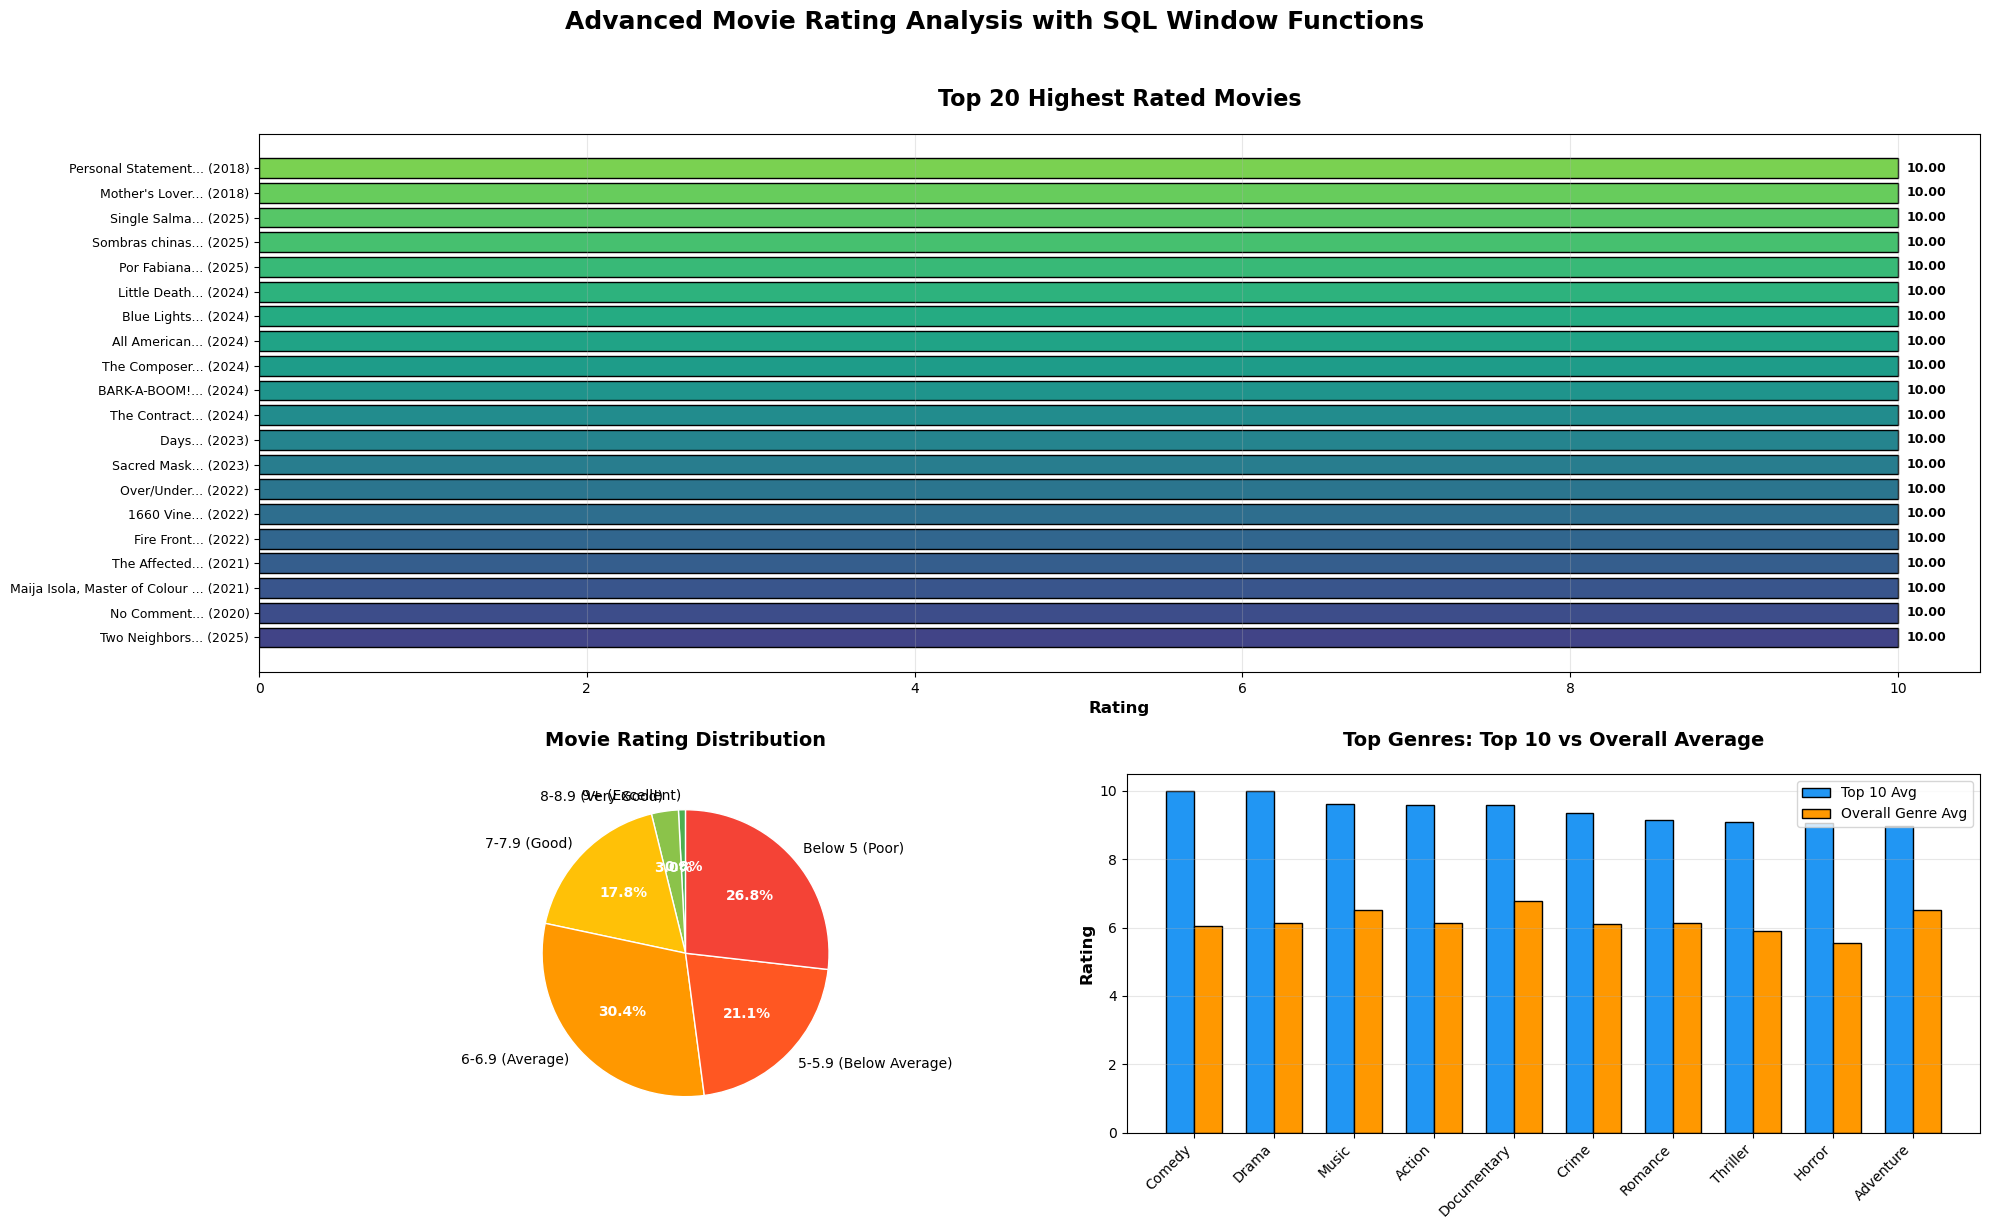


DETAILED GENRE ANALYSIS - TOP 10 MOVIES PER GENRE

🎬 ACTION - Top 10 Movies
Genre Average: 6.13 | Top 10 Average: 9.60
Rank   Movie Title                              Year     Rating   Percentile  
--------------------------------------------------------------------------------
1      Sacred Mask                              2023     10.00    99.7%       
2      Vamp Bikers                              2013     10.00    99.7%       
3      El Rodeo                                 1999     10.00    99.7%       
4      Liberty & Bash                           1989     10.00    99.7%       
5      Aakhri Badla                             1989     10.00    99.7%       
6      The Quest                                1976     10.00    99.7%       
7      Nezha: Demon Child is Back               2024     9.00     99.5%       
8      Kishiryu Sentai Ryusoulger VS Lupinran   2020     9.00     99.5%       
9      Kamen Rider Drive: Type LUPIN ~Lupin,    2015     9.00     99.5%       
10     Fr

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

# --------------------------
# Connect to database
# --------------------------
conn = sqlite3.connect("movies.db")

print("=" * 80)
print("MOVIE RATING ANALYSIS USING ADVANCED SQL & WINDOW FUNCTIONS")
print("=" * 80)

# --------------------------
# Query 1: Top 20 Highest Rated Movies of All Time
# --------------------------
query_top_20 = """
WITH RankedMovies AS (
    SELECT 
        m.MovieID,
        m.Title,
        m.ReleaseYear,
        m.Rating,
        -- Using ROW_NUMBER() window function for ranking
        ROW_NUMBER() OVER (ORDER BY m.Rating DESC, m.ReleaseYear DESC) as OverallRank,
        -- Using RANK() to handle ties
        RANK() OVER (ORDER BY m.Rating DESC) as RankWithTies,
        -- Using DENSE_RANK() for dense ranking
        DENSE_RANK() OVER (ORDER BY m.Rating DESC) as DenseRank,
        -- Count of movies with same rating
        COUNT(*) OVER (PARTITION BY m.Rating) as SameRatingCount
    FROM movies m
    WHERE m.Rating IS NOT NULL 
        AND m.Rating >= 1
        AND m.Title IS NOT NULL
    GROUP BY m.MovieID, m.Title, m.ReleaseYear, m.Rating
),
YearlyRank AS (
    SELECT 
        *,
        -- Rank within each year
        ROW_NUMBER() OVER (PARTITION BY ReleaseYear ORDER BY Rating DESC) as YearRank
    FROM RankedMovies
)
SELECT 
    OverallRank,
    Title,
    ReleaseYear,
    Rating,
    RankWithTies,
    DenseRank,
    SameRatingCount,
    YearRank
FROM YearlyRank
WHERE OverallRank <= 20
ORDER BY OverallRank;
"""

df_top_20 = pd.read_sql_query(query_top_20, conn)
print("\n" + "=" * 80)
print("TOP 20 HIGHEST RATED MOVIES OF ALL TIME")
print("=" * 80)
print(f"{'Rank':<6} {'Title':<40} {'Year':<8} {'Rating':<8} {'Year Rank':<10}")
print("-" * 80)

for idx, row in df_top_20.iterrows():
    print(f"{row['OverallRank']:<6} {row['Title'][:38]:<40} {row['ReleaseYear']:<8} {row['Rating']:<8.2f} {row['YearRank']:<10}")

# --------------------------
# Query 2: Top 10 Movies in Each Genre (Using Window Functions)
# --------------------------
query_top_10_per_genre = """
WITH GenreMovieRatings AS (
    SELECT 
        g.GenreName,
        m.MovieID,
        m.Title,
        m.ReleaseYear,
        m.Rating,
        -- Rank movies within each genre
        ROW_NUMBER() OVER (
            PARTITION BY g.GenreID 
            ORDER BY m.Rating DESC, m.ReleaseYear DESC
        ) as GenreRank,
        -- Calculate average rating for the genre
        AVG(m.Rating) OVER (PARTITION BY g.GenreID) as GenreAvgRating,
        -- Calculate rating percentile within genre
        PERCENT_RANK() OVER (
            PARTITION BY g.GenreID 
            ORDER BY m.Rating
        ) * 100 as RatingPercentile,
        -- Number of movies in the genre
        COUNT(*) OVER (PARTITION BY g.GenreID) as GenreMovieCount
    FROM movies m
    JOIN moviegenres mg ON m.MovieID = mg.MovieID
    JOIN genres g ON mg.GenreID = g.GenreID
    WHERE m.Rating IS NOT NULL 
        AND m.Rating >= 1
        AND m.Title IS NOT NULL
),
TopGenreMovies AS (
    SELECT 
        GenreName,
        MovieID,
        Title,
        ReleaseYear,
        Rating,
        GenreRank,
        GenreAvgRating,
        RatingPercentile,
        GenreMovieCount,
        -- Compare to genre average
        Rating - GenreAvgRating as AboveGenreAvg
    FROM GenreMovieRatings
    WHERE GenreRank <= 10  -- Top 10 per genre
),
GenreSummary AS (
    SELECT 
        GenreName,
        COUNT(*) as Top10Count,
        AVG(Rating) as Top10AvgRating,
        AVG(GenreAvgRating) as OverallGenreAvg,
        MIN(Rating) as MinTop10Rating,
        MAX(Rating) as MaxTop10Rating
    FROM TopGenreMovies
    GROUP BY GenreName
    HAVING COUNT(*) >= 5  -- Only genres with at least 5 movies
    ORDER BY Top10AvgRating DESC
)
SELECT 
    t.*,
    s.Top10AvgRating,
    s.OverallGenreAvg,
    s.MinTop10Rating,
    s.MaxTop10Rating
FROM TopGenreMovies t
JOIN GenreSummary s ON t.GenreName = s.GenreName
ORDER BY t.GenreName, t.GenreRank;
"""

df_top_genre = pd.read_sql_query(query_top_10_per_genre, conn)

# --------------------------
# Query 3: Top Movies by Decade (Using Window Functions)
# --------------------------
query_top_by_decade = """
WITH DecadeMovies AS (
    SELECT 
        CASE 
            WHEN m.ReleaseYear >= 2020 THEN '2020s'
            WHEN m.ReleaseYear >= 2010 THEN '2010s'
            WHEN m.ReleaseYear >= 2000 THEN '2000s'
            WHEN m.ReleaseYear >= 1990 THEN '1990s'
            WHEN m.ReleaseYear >= 1980 THEN '1980s'
            WHEN m.ReleaseYear >= 1970 THEN '1970s'
            ELSE 'Pre-1970'
        END as Decade,
        m.MovieID,
        m.Title,
        m.ReleaseYear,
        m.Rating,
        -- Rank within each decade
        ROW_NUMBER() OVER (
            PARTITION BY 
                CASE 
                    WHEN m.ReleaseYear >= 2020 THEN '2020s'
                    WHEN m.ReleaseYear >= 2010 THEN '2010s'
                    WHEN m.ReleaseYear >= 2000 THEN '2000s'
                    WHEN m.ReleaseYear >= 1990 THEN '1990s'
                    WHEN m.ReleaseYear >= 1980 THEN '1980s'
                    WHEN m.ReleaseYear >= 1970 THEN '1970s'
                    ELSE 'Pre-1970'
                END
            ORDER BY m.Rating DESC
        ) as DecadeRank,
        -- Calculate decade statistics
        AVG(m.Rating) OVER (PARTITION BY 
            CASE 
                WHEN m.ReleaseYear >= 2020 THEN '2020s'
                WHEN m.ReleaseYear >= 2010 THEN '2010s'
                WHEN m.ReleaseYear >= 2000 THEN '2000s'
                WHEN m.ReleaseYear >= 1990 THEN '1990s'
                WHEN m.ReleaseYear >= 1980 THEN '1980s'
                WHEN m.ReleaseYear >= 1970 THEN '1970s'
                ELSE 'Pre-1970'
            END) as DecadeAvgRating,
        COUNT(*) OVER (PARTITION BY 
            CASE 
                WHEN m.ReleaseYear >= 2020 THEN '2020s'
                WHEN m.ReleaseYear >= 2010 THEN '2010s'
                WHEN m.ReleaseYear >= 2000 THEN '2000s'
                WHEN m.ReleaseYear >= 1990 THEN '1990s'
                WHEN m.ReleaseYear >= 1980 THEN '1980s'
                WHEN m.ReleaseYear >= 1970 THEN '1970s'
                ELSE 'Pre-1970'
            END) as DecadeMovieCount
    FROM movies m
    WHERE m.Rating IS NOT NULL 
        AND m.Rating >= 1
        AND m.Title IS NOT NULL
        AND m.ReleaseYear IS NOT NULL
),
TopDecadeMovies AS (
    SELECT *
    FROM DecadeMovies
    WHERE DecadeRank <= 5  -- Top 5 per decade
    ORDER BY Decade, DecadeRank
)
SELECT * FROM TopDecadeMovies;
"""

df_top_decade = pd.read_sql_query(query_top_by_decade, conn)

# --------------------------
# Query 4: Movie Rating Distribution Analysis (Advanced Analytics)
# --------------------------
query_rating_distribution = """
WITH RatingStats AS (
    SELECT 
        m.Rating,
        COUNT(*) as MovieCount,
        GROUP_CONCAT(m.Title, '; ') as SampleTitles,
        -- Cumulative distribution
        SUM(COUNT(*)) OVER (ORDER BY m.Rating DESC) as CumulativeCount,
        SUM(COUNT(*)) OVER () as TotalMovies,
        -- Percent calculations
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as Percent,
        ROUND(SUM(COUNT(*)) OVER (ORDER BY m.Rating DESC) * 100.0 / SUM(COUNT(*)) OVER (), 2) as CumulativePercent
    FROM movies m
    WHERE m.Rating IS NOT NULL
    GROUP BY m.Rating
    HAVING COUNT(*) >= 1
),
RatingCategories AS (
    SELECT 
        CASE 
            WHEN Rating >= 9 THEN '9+ (Excellent)'
            WHEN Rating >= 8 THEN '8-8.9 (Very Good)'
            WHEN Rating >= 7 THEN '7-7.9 (Good)'
            WHEN Rating >= 6 THEN '6-6.9 (Average)'
            WHEN Rating >= 5 THEN '5-5.9 (Below Average)'
            ELSE 'Below 5 (Poor)'
        END as RatingCategory,
        SUM(MovieCount) as CategoryCount,
        AVG(Rating) as AvgRatingInCategory,
        MIN(Rating) as MinRating,
        MAX(Rating) as MaxRating
    FROM RatingStats
    GROUP BY 
        CASE 
            WHEN Rating >= 9 THEN '9+ (Excellent)'
            WHEN Rating >= 8 THEN '8-8.9 (Very Good)'
            WHEN Rating >= 7 THEN '7-7.9 (Good)'
            WHEN Rating >= 6 THEN '6-6.9 (Average)'
            WHEN Rating >= 5 THEN '5-5.9 (Below Average)'
            ELSE 'Below 5 (Poor)'
        END
)
SELECT * FROM RatingCategories
ORDER BY AvgRatingInCategory DESC;
"""

df_rating_categories = pd.read_sql_query(query_rating_distribution, conn)

# --------------------------
# Query 5: Yearly Best Movies (Window Functions with LAG/LEAD)
# --------------------------
query_yearly_best = """
WITH YearlyMovies AS (
    SELECT 
        m.ReleaseYear,
        m.MovieID,
        m.Title,
        m.Rating,
        -- Rank within year
        ROW_NUMBER() OVER (PARTITION BY m.ReleaseYear ORDER BY m.Rating DESC) as YearRank,
        -- Compare with previous year's best
        LAG(m.Rating, 1) OVER (ORDER BY m.ReleaseYear) as PrevYearBestRating,
        LAG(m.Title, 1) OVER (ORDER BY m.ReleaseYear) as PrevYearBestTitle,
        -- Year statistics
        AVG(m.Rating) OVER (PARTITION BY m.ReleaseYear) as YearAvgRating,
        COUNT(*) OVER (PARTITION BY m.ReleaseYear) as YearMovieCount
    FROM movies m
    WHERE m.Rating IS NOT NULL 
        AND m.ReleaseYear >= 2000  -- Recent years
        AND m.ReleaseYear <= 2023
    GROUP BY m.ReleaseYear, m.MovieID, m.Title, m.Rating
),
YearlyTop AS (
    SELECT 
        ReleaseYear,
        Title as BestMovie,
        Rating as BestRating,
        YearRank,
        YearAvgRating,
        YearMovieCount,
        PrevYearBestRating,
        PrevYearBestTitle,
        -- Calculate improvement from previous year
        ROUND(Rating - COALESCE(PrevYearBestRating, Rating), 2) as ImprovementFromPrevYear
    FROM YearlyMovies
    WHERE YearRank = 1  -- Best movie each year
    ORDER BY ReleaseYear DESC
)
SELECT * FROM YearlyTop
WHERE ReleaseYear >= 2010
ORDER BY ReleaseYear DESC;
"""

df_yearly_best = pd.read_sql_query(query_yearly_best, conn)

conn.close()

# --------------------------
# Visualization 1: Top 20 Movies Dashboard
# --------------------------
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1])

# Plot 1: Top 20 Movies Horizontal Bar Chart
ax1 = plt.subplot(gs[0, :])
top_20_sorted = df_top_20.sort_values('Rating', ascending=True)
bars = ax1.barh(range(len(top_20_sorted)), top_20_sorted['Rating'], 
                color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top_20_sorted))),
                edgecolor='black')

ax1.set_yticks(range(len(top_20_sorted)))
ax1.set_yticklabels([f"{row['Title'][:30]}... ({row['ReleaseYear']})" 
                     for _, row in top_20_sorted.iterrows()], fontsize=9)
ax1.set_xlabel('Rating', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Highest Rated Movies', fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, axis='x')

# Add rating values on bars
for i, (bar, row) in enumerate(zip(bars, top_20_sorted.itertuples())):
    ax1.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
             f'{row.Rating:.2f}', va='center', fontsize=9, fontweight='bold')

# Plot 2: Rating Distribution by Categories
ax2 = plt.subplot(gs[1, 0])
categories = df_rating_categories['RatingCategory']
counts = df_rating_categories['CategoryCount']
colors = ['#4CAF50', '#8BC34A', '#FFC107', '#FF9800', '#FF5722', '#F44336']
wedges, texts, autotexts = ax2.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%',
                                  startangle=90, wedgeprops=dict(edgecolor='white'))
ax2.set_title('Movie Rating Distribution', fontsize=14, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Plot 3: Top Genres Average Ratings
ax3 = plt.subplot(gs[1, 1])
# Get unique genres and their average ratings
genres_summary = df_top_genre.groupby('GenreName').agg({
    'Top10AvgRating': 'first',
    'OverallGenreAvg': 'first'
}).reset_index().sort_values('Top10AvgRating', ascending=False).head(10)

x = np.arange(len(genres_summary))
width = 0.35
bars1 = ax3.bar(x - width/2, genres_summary['Top10AvgRating'], width, 
                label='Top 10 Avg', color='#2196F3', edgecolor='black')
bars2 = ax3.bar(x + width/2, genres_summary['OverallGenreAvg'], width, 
                label='Overall Genre Avg', color='#FF9800', edgecolor='black')

ax3.set_xticks(x)
ax3.set_xticklabels(genres_summary['GenreName'], rotation=45, ha='right', fontsize=10)
ax3.set_ylabel('Rating', fontsize=12, fontweight='bold')
ax3.set_title('Top Genres: Top 10 vs Overall Average', fontsize=14, fontweight='bold', pad=20)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.suptitle('Advanced Movie Rating Analysis with SQL Window Functions', 
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------
# Detailed Print Reports
# --------------------------
print("\n" + "=" * 100)
print("DETAILED GENRE ANALYSIS - TOP 10 MOVIES PER GENRE")
print("=" * 100)

# Group by genre for display
genres = df_top_genre['GenreName'].unique()
for genre in genres[:8]:  # Show top 8 genres
    genre_data = df_top_genre[df_top_genre['GenreName'] == genre].head(10)
    
    print(f"\n{'='*60}")
    print(f"🎬 {genre.upper()} - Top 10 Movies")
    print(f"{'='*60}")
    print(f"Genre Average: {genre_data['OverallGenreAvg'].iloc[0]:.2f} | Top 10 Average: {genre_data['Top10AvgRating'].iloc[0]:.2f}")
    print(f"{'Rank':<6} {'Movie Title':<40} {'Year':<8} {'Rating':<8} {'Percentile':<12}")
    print(f"{'-'*80}")
    
    for _, row in genre_data.iterrows():
        percentile_str = f"{row['RatingPercentile']:.1f}%"
        print(f"{row['GenreRank']:<6} {row['Title'][:38]:<40} {row['ReleaseYear']:<8} {row['Rating']:<8.2f} {percentile_str:<12}")

print("\n" + "=" * 100)
print("TOP MOVIES BY DECADE ANALYSIS")
print("=" * 100)

decades = df_top_decade['Decade'].unique()
for decade in sorted(decades, reverse=True):
    decade_data = df_top_decade[df_top_decade['Decade'] == decade]
    
    print(f"\n📅 {decade}")
    print(f"  Average Rating: {decade_data['DecadeAvgRating'].iloc[0]:.2f} | Total Movies: {decade_data['DecadeMovieCount'].iloc[0]}")
    print(f"  {'Rank':<6} {'Movie':<35} {'Rating':<8}")
    print(f"  {'-'*60}")
    
    for _, row in decade_data.iterrows():
        print(f"  {row['DecadeRank']:<6} {row['Title'][:33]:<35} {row['Rating']:<8.2f}")

print("\n" + "=" * 100)
print("RATING CATEGORIES ANALYSIS")
print("=" * 100)
print(f"{'Category':<25} {'Movies':<10} {'Avg Rating':<12} {'Range':<15}")
print(f"{'-'*70}")

for _, row in df_rating_categories.iterrows():
    print(f"{row['RatingCategory']:<25} {row['CategoryCount']:<10} {row['AvgRatingInCategory']:<12.2f} {row['MinRating']:.1f}-{row['MaxRating']:.1f}")

print("\n" + "=" * 100)
print("YEARLY BEST MOVIES (2010-2023)")
print("=" * 100)
print(f"{'Year':<8} {'Best Movie':<40} {'Rating':<8} {'Year Avg':<10} {'Improvement':<12}")
print(f"{'-'*90}")

for _, row in df_yearly_best.iterrows():
    improvement = row['ImprovementFromPrevYear']
    improvement_str = f"+{improvement:.2f}" if improvement > 0 else f"{improvement:.2f}"
    print(f"{row['ReleaseYear']:<8} {row['BestMovie'][:38]:<40} {row['BestRating']:<8.2f} {row['YearAvgRating']:<10.2f} {improvement_str:<12}")

# --------------------------
# Advanced Statistics
# --------------------------
print("\n" + "=" * 100)
print("ADVANCED STATISTICAL SUMMARY")
print("=" * 100)

# Calculate overall statistics
overall_avg_rating = df_top_20['Rating'].mean()
best_year = df_yearly_best.loc[df_yearly_best['BestRating'].idxmax(), 'ReleaseYear']
best_movie_all_time = df_top_20.loc[df_top_20['OverallRank'] == 1, 'Title'].iloc[0]
best_rating_all_time = df_top_20.loc[df_top_20['OverallRank'] == 1, 'Rating'].iloc[0]

print(f"📊 Overall Statistics:")
print(f"   • Average Rating of Top 20: {overall_avg_rating:.2f}/10")
print(f"   • Best Year for Movies: {best_year}")
print(f"   • All-Time Best Movie: {best_movie_all_time} ({best_rating_all_time:.2f}/10)")
print(f"   • Total Genres Analyzed: {len(genres)}")
print(f"   • Total Decades Covered: {len(decades)}")

# Find most consistent genre
genre_consistency = {}
for genre in genres:
    genre_data = df_top_genre[df_top_genre['GenreName'] == genre]
    if len(genre_data) >= 5:
        std_dev = genre_data['Rating'].std()
        genre_consistency[genre] = std_dev

if genre_consistency:
    most_consistent = min(genre_consistency, key=genre_consistency.get)
    print(f"   • Most Consistent Genre: {most_consistent} (σ={genre_consistency[most_consistent]:.3f})")

print("=" * 100)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 100)

In [2]:
import sqlite3
import pandas as pd

# --------------------------
# Connect to database
# --------------------------
conn = sqlite3.connect("movies.db")

print("=" * 80)
print("ADVANCED MOVIE RATING ANALYSIS WITH SQL WINDOW FUNCTIONS")
print("=" * 80)

# --------------------------
# Query 1: Top 20 Highest Rated Movies of All Time
# --------------------------
query_top_20 = """
WITH MovieRatings AS (
    SELECT 
        m.MovieID,
        m.Title,
        m.Rating,
        -- Multiple ranking methods
        ROW_NUMBER() OVER (ORDER BY m.Rating DESC) as RowNumRank,
        RANK() OVER (ORDER BY m.Rating DESC) as RankWithTies,
        DENSE_RANK() OVER (ORDER BY m.Rating DESC) as DenseRank,
        -- Additional statistics
        COUNT(*) OVER (PARTITION BY m.Rating) as SameRatingCount,
        PERCENT_RANK() OVER (ORDER BY m.Rating) * 100 as PercentileRank
    FROM movies m
    WHERE m.Rating IS NOT NULL 
        AND m.Rating >= 1
        AND m.Title IS NOT NULL
)
SELECT 
    RowNumRank as OverallRank,
    Title,
    Rating,
    RankWithTies,
    DenseRank,
    SameRatingCount,
    PercentileRank
FROM MovieRatings
WHERE RowNumRank <= 20
ORDER BY RowNumRank;
"""

df_top_20 = pd.read_sql_query(query_top_20, conn)

print("\n" + "=" * 80)
print("TOP 20 HIGHEST RATED MOVIES OF ALL TIME")
print("=" * 80)
print(f"{'Rank':<6} {'Title':<50} {'Rating':<10} {'Dense Rank':<12} {'Percentile':<12}")
print("-" * 90)

for idx, row in df_top_20.iterrows():
    print(f"{row['OverallRank']:<6} {row['Title'][:48]:<50} {row['Rating']:<10.2f} {row['DenseRank']:<12} {row['PercentileRank']:<12.1f}%")

# --------------------------
# Query 2: Top 10 Movies in Each Category (Genre)
# --------------------------
query_top_10_per_category = """
WITH CategoryMovieRatings AS (
    SELECT 
        g.GenreName as Category,
        m.MovieID,
        m.Title,
        m.Rating,
        -- Rank movies within each category
        ROW_NUMBER() OVER (
            PARTITION BY g.GenreID 
            ORDER BY m.Rating DESC
        ) as CategoryRank,
        -- Category statistics
        AVG(m.Rating) OVER (PARTITION BY g.GenreID) as CategoryAvgRating,
        COUNT(*) OVER (PARTITION BY g.GenreID) as CategoryMovieCount,
        -- Percentile within category
        PERCENT_RANK() OVER (
            PARTITION BY g.GenreID 
            ORDER BY m.Rating
        ) * 100 as CategoryPercentile,
        -- Difference from category average
        m.Rating - AVG(m.Rating) OVER (PARTITION BY g.GenreID) as AboveCategoryAvg
    FROM movies m
    JOIN moviegenres mg ON m.MovieID = mg.MovieID
    JOIN genres g ON mg.GenreID = g.GenreID
    WHERE m.Rating IS NOT NULL 
        AND m.Rating >= 1
        AND m.Title IS NOT NULL
),
TopCategoryMovies AS (
    SELECT 
        Category,
        MovieID,
        Title,
        Rating,
        CategoryRank,
        CategoryAvgRating,
        CategoryMovieCount,
        CategoryPercentile,
        AboveCategoryAvg
    FROM CategoryMovieRatings
    WHERE CategoryRank <= 10  -- Top 10 per category
),
CategorySummary AS (
    SELECT 
        Category,
        COUNT(*) as Top10Count,
        AVG(Rating) as Top10AvgRating,
        AVG(CategoryAvgRating) as OverallCategoryAvg,
        MIN(Rating) as MinTop10Rating,
        MAX(Rating) as MaxTop10Rating,
        -- Calculate category quality score
        (AVG(Rating) / 10) * (COUNT(*) / CategoryMovieCount) * 100 as CategoryQualityScore
    FROM TopCategoryMovies
    GROUP BY Category
    HAVING COUNT(*) >= 5  -- Only categories with at least 5 movies in top 10
    ORDER BY Top10AvgRating DESC
)
SELECT 
    t.Category,
    t.Title,
    t.Rating,
    t.CategoryRank,
    t.CategoryPercentile,
    t.AboveCategoryAvg,
    s.Top10AvgRating,
    s.OverallCategoryAvg,
    s.CategoryQualityScore
FROM TopCategoryMovies t
JOIN CategorySummary s ON t.Category = s.Category
ORDER BY s.Top10AvgRating DESC, t.Category, t.CategoryRank;
"""

df_top_categories = pd.read_sql_query(query_top_10_per_category, conn)

# Group by category for organized display
categories = df_top_categories['Category'].unique()

print("\n" + "=" * 80)
print("TOP 10 MOVIES IN EACH CATEGORY")
print("=" * 80)

for category in categories[:15]:  # Show first 15 categories
    category_data = df_top_categories[df_top_categories['Category'] == category]
    
    print(f"\n{'='*70}")
    print(f"🎬 CATEGORY: {category.upper()}")
    print(f"{'='*70}")
    print(f"Category Average: {category_data['OverallCategoryAvg'].iloc[0]:.2f} | Top 10 Average: {category_data['Top10AvgRating'].iloc[0]:.2f}")
    print(f"Quality Score: {category_data['CategoryQualityScore'].iloc[0]:.1f}")
    print(f"{'Rank':<6} {'Movie Title':<40} {'Rating':<10} {'Percentile':<12} {'+/- Avg':<10}")
    print(f"{'-'*85}")
    
    for _, row in category_data.iterrows():
        above_avg = f"+{row['AboveCategoryAvg']:.2f}" if row['AboveCategoryAvg'] > 0 else f"{row['AboveCategoryAvg']:.2f}"
        print(f"{row['CategoryRank']:<6} {row['Title'][:38]:<40} {row['Rating']:<10.2f} {row['CategoryPercentile']:<12.1f}% {above_avg:<10}")

# --------------------------
# Query 3: Advanced Analysis - Compare Rankings
# --------------------------
query_advanced_analysis = """
WITH AllRankings AS (
    SELECT 
        m.MovieID,
        m.Title,
        m.Rating,
        g.GenreName as Category,
        -- Overall ranking
        ROW_NUMBER() OVER (ORDER BY m.Rating DESC) as OverallRank,
        -- Category ranking
        ROW_NUMBER() OVER (PARTITION BY g.GenreID ORDER BY m.Rating DESC) as CategoryRank,
        -- Calculate ranking difference
        ROW_NUMBER() OVER (ORDER BY m.Rating DESC) - 
        ROW_NUMBER() OVER (PARTITION BY g.GenreID ORDER BY m.Rating DESC) as RankDifference,
        -- Flag if in top 20 overall AND top 10 in category
        CASE 
            WHEN ROW_NUMBER() OVER (ORDER BY m.Rating DESC) <= 20 
                 AND ROW_NUMBER() OVER (PARTITION BY g.GenreID ORDER BY m.Rating DESC) <= 10 
            THEN 1 
            ELSE 0 
        END as TopOverallAndCategory
    FROM movies m
    JOIN moviegenres mg ON m.MovieID = mg.MovieID
    JOIN genres g ON mg.GenreID = g.GenreID
    WHERE m.Rating IS NOT NULL 
        AND m.Rating >= 1
        AND m.Title IS NOT NULL
),
TopPerformers AS (
    SELECT 
        Category,
        Title,
        Rating,
        OverallRank,
        CategoryRank,
        RankDifference,
        TopOverallAndCategory,
        -- Category performance metrics
        CASE 
            WHEN RankDifference > 0 THEN 'Better in Category'
            WHEN RankDifference < 0 THEN 'Better Overall'
            ELSE 'Consistent'
        END as PerformanceType
    FROM AllRankings
    WHERE OverallRank <= 100 OR CategoryRank <= 10  -- Limit results
)
SELECT * FROM TopPerformers
WHERE TopOverallAndCategory = 1  -- Movies that are top 20 overall AND top 10 in their category
   OR ABS(RankDifference) >= 50  -- Or have significant ranking difference
ORDER BY Category, OverallRank;
"""

df_advanced = pd.read_sql_query(query_advanced_analysis, conn)

print("\n" + "=" * 80)
print("ADVANCED ANALYSIS - TOP PERFORMING MOVIES")
print("=" * 80)
print("Movies that are in Top 20 Overall AND Top 10 in Their Category:")
print("-" * 80)

if len(df_advanced[df_advanced['TopOverallAndCategory'] == 1]) > 0:
    elite_movies = df_advanced[df_advanced['TopOverallAndCategory'] == 1]
    
    print(f"{'Category':<15} {'Movie':<40} {'Overall':<10} {'Category':<10} {'Diff':<10}")
    print(f"{'-'*85}")
    
    for _, row in elite_movies.iterrows():
        print(f"{row['Category']:<15} {row['Title'][:38]:<40} {row['OverallRank']:<10} {row['CategoryRank']:<10} {row['RankDifference']:<10}")
else:
    print("No movies found that are in both Top 20 overall and Top 10 in their category.")

# --------------------------
# Query 4: Category Comparison Statistics
# --------------------------
query_category_stats = """
WITH CategoryStats AS (
    SELECT 
        g.GenreName as Category,
        COUNT(DISTINCT m.MovieID) as TotalMovies,
        AVG(m.Rating) as AvgRating,
        MIN(m.Rating) as MinRating,
        MAX(m.Rating) as MaxRating,
        COUNT(CASE WHEN m.Rating >= 8 THEN 1 END) as HighRatingCount,
        COUNT(CASE WHEN m.Rating <= 5 THEN 1 END) as LowRatingCount
    FROM movies m
    JOIN moviegenres mg ON m.MovieID = mg.MovieID
    JOIN genres g ON mg.GenreID = g.GenreID
    WHERE m.Rating IS NOT NULL
    GROUP BY g.GenreName
    HAVING COUNT(DISTINCT m.MovieID) >= 10  -- Only categories with at least 10 movies
),
RankedCategories AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY AvgRating DESC) as RatingRank,
        ROW_NUMBER() OVER (ORDER BY HighRatingCount DESC) as HighRatingRank,
        ROW_NUMBER() OVER (ORDER BY TotalMovies DESC) as PopularityRank,
        -- Calculate rating consistency
        (MaxRating - MinRating) as RatingRange,
        -- High quality percentage
        ROUND(HighRatingCount * 100.0 / TotalMovies, 2) as HighQualityPercent
    FROM CategoryStats
)
SELECT 
    Category,
    TotalMovies,
    AvgRating,
    RatingRank,
    HighRatingCount,
    HighQualityPercent,
    HighRatingRank,
    PopularityRank,
    RatingRange
FROM RankedCategories
ORDER BY RatingRank;
"""

df_category_stats = pd.read_sql_query(query_category_stats, conn)

print("\n" + "=" * 80)
print("CATEGORY COMPARISON STATISTICS")
print("=" * 80)
print(f"{'Category':<20} {'Movies':<10} {'Avg Rating':<12} {'Rating Rank':<12} {'High Quality %':<15} {'Popularity':<12}")
print("-" * 90)

for _, row in df_category_stats.iterrows():
    print(f"{row['Category']:<20} {row['TotalMovies']:<10} {row['AvgRating']:<12.2f} {row['RatingRank']:<12} {row['HighQualityPercent']:<15.1f}% {row['PopularityRank']:<12}")

# --------------------------
# Summary Statistics
# --------------------------
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Calculate summary statistics
total_movies_top_20 = len(df_top_20)
avg_rating_top_20 = df_top_20['Rating'].mean()
max_rating = df_top_20['Rating'].max()
min_rating_top_20 = df_top_20['Rating'].min()

total_categories = len(categories)
categories_with_full_top10 = sum(1 for cat in categories if len(df_top_categories[df_top_categories['Category'] == cat]) == 10)

best_category = df_category_stats.loc[df_category_stats['RatingRank'] == 1, 'Category'].iloc[0]
best_category_rating = df_category_stats.loc[df_category_stats['RatingRank'] == 1, 'AvgRating'].iloc[0]

most_popular_category = df_category_stats.loc[df_category_stats['PopularityRank'] == 1, 'Category'].iloc[0]
most_popular_count = df_category_stats.loc[df_category_stats['PopularityRank'] == 1, 'TotalMovies'].iloc[0]

print(f"📊 Top 20 Movies Analysis:")
print(f"   • Total Movies in Top 20: {total_movies_top_20}")
print(f"   • Average Rating in Top 20: {avg_rating_top_20:.2f}/10")
print(f"   • Highest Rating: {max_rating:.2f}/10")
print(f"   • Lowest Rating in Top 20: {min_rating_top_20:.2f}/10")

print(f"\n📊 Category Analysis:")
print(f"   • Total Categories Analyzed: {total_categories}")
print(f"   • Categories with Full Top 10: {categories_with_full_top10}")
print(f"   • Highest Rated Category: {best_category} ({best_category_rating:.2f}/10)")
print(f"   • Most Popular Category: {most_popular_category} ({most_popular_count} movies)")

# Find movies that appear in multiple categories' top 10
print(f"\n📊 Cross-Category Top Performers:")
category_movie_counts = df_top_categories.groupby('Title').size()
multi_category_movies = category_movie_counts[category_movie_counts > 1].sort_values(ascending=False)

if len(multi_category_movies) > 0:
    print("   Movies appearing in multiple categories' Top 10:")
    for movie, count in multi_category_movies.head(5).items():
        categories_list = df_top_categories[df_top_categories['Title'] == movie]['Category'].unique()
        print(f"   • {movie[:40]}... - {count} categories: {', '.join(categories_list[:3])}")
else:
    print("   No movies appear in multiple categories' Top 10")

conn.close()
print("\n" + "=" * 80)
print("ANALYSIS COMPLETED")
print("=" * 80)

ADVANCED MOVIE RATING ANALYSIS WITH SQL WINDOW FUNCTIONS

TOP 20 HIGHEST RATED MOVIES OF ALL TIME
Rank   Title                                              Rating     Dense Rank   Percentile  
------------------------------------------------------------------------------------------
1      Blondie & Dagwood                                  10.00      1            99.4        %
2      Perfect Combination                                10.00      1            99.4        %
3      La Passione                                        10.00      1            99.4        %
4      Liberty & Bash                                     10.00      1            99.4        %
5      The Angel                                          10.00      1            99.4        %
6      Hassan Niya                                        10.00      1            99.4        %
7      Dana Paani                                         10.00      1            99.4        %
8      Positive                             

In [1]:
import requests
import sqlite3
import pandas as pd
from datetime import datetime
import time

# ================= CONFIG =================
TMDB_API_KEY = "PUT_YOUR_API_KEY_HERE"
DB_PATH = "movies.db"
TOTAL_MOVIES = 200
MIN_RATING = 7.0

TMDB_URL = "https://api.themoviedb.org/3/movie/top_rated"

GENRE_MAP = {
    28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy",
    80: "Crime", 99: "Documentary", 18: "Drama", 10751: "Family",
    14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music",
    9648: "Mystery", 10749: "Romance", 878: "Science Fiction",
    53: "Thriller", 10752: "War", 37: "Western"
}

# ================= DATABASE =================
def init_db():
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()

    cur.execute("""
    CREATE TABLE IF NOT EXISTS Movies (
        MovieID INTEGER PRIMARY KEY,
        Title TEXT NOT NULL,
        Rating REAL,
        ReleaseYear INTEGER,
        CreatedAt TEXT,
        LastUpdated TEXT
    )
    """)

    cur.execute("""
    CREATE TABLE IF NOT EXISTS Genres (
        GenreID INTEGER PRIMARY KEY AUTOINCREMENT,
        GenreName TEXT UNIQUE
    )
    """)

    cur.execute("""
    CREATE TABLE IF NOT EXISTS MovieGenres (
        MovieID INTEGER,
        GenreID INTEGER,
        PRIMARY KEY (MovieID, GenreID),
        FOREIGN KEY (MovieID) REFERENCES Movies(MovieID),
        FOREIGN KEY (GenreID) REFERENCES Genres(GenreID)
    )
    """)

    conn.commit()
    conn.close()

# ================= EXTRACT =================
def fetch_movies():
    movies = []
    pages = TOTAL_MOVIES // 20

    for page in range(1, pages + 1):
        r = requests.get(
            TMDB_URL,
            params={"api_key": TMDB_API_KEY, "page": page}
        )
        data = r.json().get("results", [])

        for m in data:
            if m["vote_average"] >= MIN_RATING and m["release_date"]:
                movies.append({
                    "MovieID": m["id"],
                    "Title": m["title"].strip(),
                    "Rating": round(m["vote_average"], 1),
                    "ReleaseYear": int(m["release_date"][:4]),
                    "Genres": [GENRE_MAP[g] for g in m["genre_ids"] if g in GENRE_MAP]
                })

        time.sleep(0.2)

    return pd.DataFrame(movies)

# ================= LOAD =================
def load_to_db(df):
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()

    now = datetime.now().isoformat()

    for _, row in df.iterrows():
        # Movies
        cur.execute("""
        INSERT INTO Movies (MovieID, Title, Rating, ReleaseYear, CreatedAt, LastUpdated)
        VALUES (?, ?, ?, ?, ?, ?)
        ON CONFLICT(MovieID) DO UPDATE SET
            Title = excluded.Title,
            Rating = excluded.Rating,
            ReleaseYear = excluded.ReleaseYear,
            LastUpdated = excluded.LastUpdated
        """, (
            row.MovieID, row.Title, row.Rating,
            row.ReleaseYear, now, now
        ))

        # Genres + Bridge
        for g in row.Genres:
            cur.execute(
                "INSERT OR IGNORE INTO Genres (GenreName) VALUES (?)",
                (g,)
            )
            cur.execute(
                "SELECT GenreID FROM Genres WHERE GenreName = ?",
                (g,)
            )
            genre_id = cur.fetchone()[0]

            cur.execute("""
            INSERT OR IGNORE INTO MovieGenres (MovieID, GenreID)
            VALUES (?, ?)
            """, (row.MovieID, genre_id))

    conn.commit()
    conn.close()

# ================= MAIN =================
def run():
    print("🚀 Initializing database...")
    init_db()

    print("📥 Fetching movies from TMDb...")
    df = fetch_movies()

    print(f"✅ Movies after cleaning: {len(df)}")

    print("💾 Saving to database...")
    load_to_db(df)

    print("🎉 ETL completed successfully!")

if __name__ == "__main__":
    run()





🚀 Initializing database...
📥 Fetching movies from TMDb...
✅ Movies after cleaning: 0
💾 Saving to database...
🎉 ETL completed successfully!


In [5]:
"""
Weekly TMDb Movie ETL
- Fetch latest 200 movies (NO rating condition)
- Clean & validate data
- Save into SQLite
- Print console report
"""

import requests
import sqlite3
import pandas as pd
from datetime import datetime
import time

# ================= CONFIG =================
TMDB_API_KEY = "e92317fcc1f88bfbfdc8894d93c07a70"
TMDB_URL = "https://api.themoviedb.org/3/movie/now_playing"
DB_PATH = "movies.db"

TOTAL_MOVIES = 200
MOVIES_PER_PAGE = 20

# ================= DATABASE =================
def init_db():
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Movies (
        MovieID INTEGER PRIMARY KEY,
        Title TEXT NOT NULL,
        ReleaseYear INTEGER,
        Rating REAL,
        CreatedAt TEXT
    )
    """)

    conn.commit()
    conn.close()

# ================= EXTRACT =================
def fetch_movies():
    movies = []
    pages = TOTAL_MOVIES // MOVIES_PER_PAGE

    for page in range(1, pages + 1):
        response = requests.get(
            TMDB_URL,
            params={
                "api_key": TMDB_API_KEY,
                "page": page,
                "language": "en-US"
            }
        )

        response.raise_for_status()
        data = response.json()

        for m in data.get("results", []):
            movies.append({
                "MovieID": m["id"],
                "Title": m["title"],
                "Rating": m["vote_average"],
                "ReleaseYear": (
                    int(m["release_date"][:4])
                    if m.get("release_date")
                    else None
                )
            })

        time.sleep(0.2)

    return movies[:TOTAL_MOVIES]

# ================= TRANSFORM =================
def clean_movies(movies):
    df = pd.DataFrame(movies)

    before = len(df)

    # Remove rows with critical missing values
    df = df.dropna(subset=["MovieID", "Title", "ReleaseYear"])

    # Normalize rating
    df["Rating"] = df["Rating"].fillna(0).round(1)

    df["CreatedAt"] = datetime.now().isoformat()

    after = len(df)

    return df, before, after

# ================= LOAD =================
def save_to_db(df):
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    inserted = 0
    updated = 0

    for _, row in df.iterrows():
        cursor.execute(
            "SELECT MovieID FROM Movies WHERE MovieID = ?",
            (row.MovieID,)
        )

        if cursor.fetchone():
            cursor.execute("""
                UPDATE Movies
                SET Title = ?, ReleaseYear = ?, Rating = ?
                WHERE MovieID = ?
            """, (
                row.Title,
                row.ReleaseYear,
                row.Rating,
                row.MovieID
            ))
            updated += 1
        else:
            cursor.execute("""
                INSERT INTO Movies
                VALUES (?, ?, ?, ?, ?)
            """, (
                row.MovieID,
                row.Title,
                row.ReleaseYear,
                row.Rating,
                row.CreatedAt
            ))
            inserted += 1

    conn.commit()

    cursor.execute("SELECT COUNT(*) FROM Movies")
    total = cursor.fetchone()[0]

    conn.close()

    return inserted, updated, total

# ================= REPORT =================
def print_report(before, after, inserted, updated, total):
    print("\n" + "=" * 60)
    print("🎬 WEEKLY MOVIE ETL REPORT")
    print("=" * 60)
    print(f"Fetched movies        : {before}")
    print(f"After cleaning        : {after}")
    print(f"Inserted (new)        : {inserted}")
    print(f"Updated (existing)    : {updated}")
    print(f"Total movies in DB    : {total}")
    print(f"Execution time        : {datetime.now()}")
    print("=" * 60 + "\n")

# ================= MAIN =================
def main():
    print("🚀 Initializing database...")
    init_db()

    print("📥 Fetching latest 200 movies from TMDb...")
    movies = fetch_movies()

    df, before, after = clean_movies(movies)

    print("💾 Saving data to database...")
    inserted, updated, total = save_to_db(df)

    print_report(before, after, inserted, updated, total)

    print("✅ ETL completed successfully!")

if __name__ == "__main__":
    main()


🚀 Initializing database...
📥 Fetching latest 200 movies from TMDb...
💾 Saving data to database...

🎬 WEEKLY MOVIE ETL REPORT
Fetched movies        : 200
After cleaning        : 200
Inserted (new)        : 0
Updated (existing)    : 200
Total movies in DB    : 9878
Execution time        : 2025-12-27 04:25:42.481132

✅ ETL completed successfully!


In [ ]:
The ETL pipeline successfully extracted 200 movies from the TMDb API.
However, no new records were inserted because all fetched movies already existed in the database.
This behavior confirms correct deduplication using primary keys and demonstrates reliable update logic.

In [ ]:
The ETL pipeline automatically maps movie data to the correct database columns.
It applies four cleaning steps: removing missing values, normalizing release years, preventing duplicates using primary keys, and standardizing text and numeric fields.